In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = RandomForestClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = RandomForestClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1785
           1       0.65      0.34      0.45       604
           2       0.48      0.36      0.41       258
           3       0.45      0.25      0.33        59
           4       0.14      0.11      0.12         9

    accuracy                           0.72      2715
   macro avg       0.50      0.40      0.43      2715
weighted avg       0.70      0.72      0.70      2715



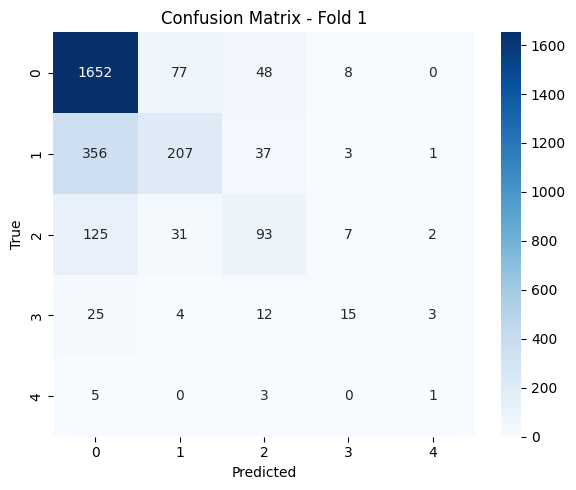

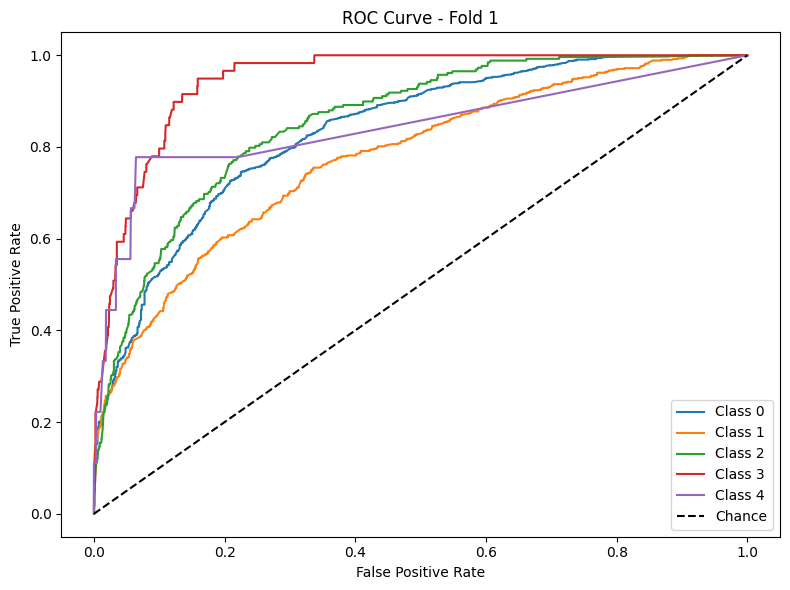


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1786
           1       0.59      0.35      0.44       603
           2       0.54      0.41      0.47       258
           3       0.34      0.17      0.23        59
           4       0.20      0.12      0.15         8

    accuracy                           0.72      2714
   macro avg       0.49      0.39      0.42      2714
weighted avg       0.69      0.72      0.70      2714



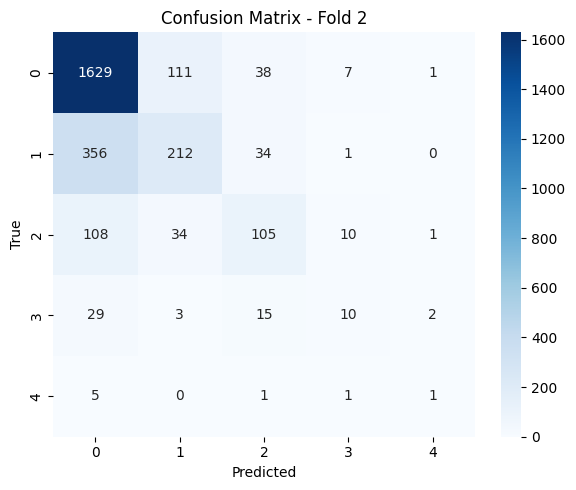

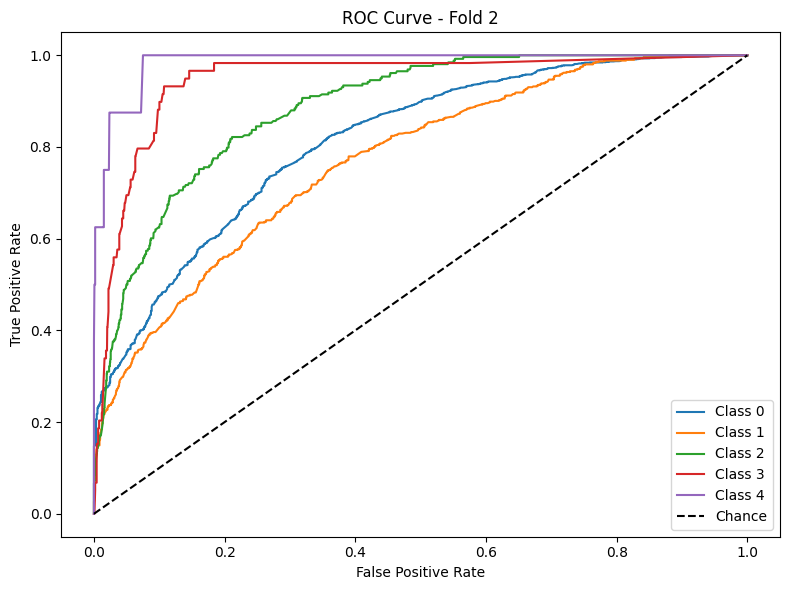


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1786
           1       0.58      0.39      0.47       603
           2       0.51      0.36      0.42       258
           3       0.55      0.29      0.38        59
           4       0.38      0.38      0.38         8

    accuracy                           0.73      2714
   macro avg       0.56      0.46      0.50      2714
weighted avg       0.70      0.73      0.70      2714



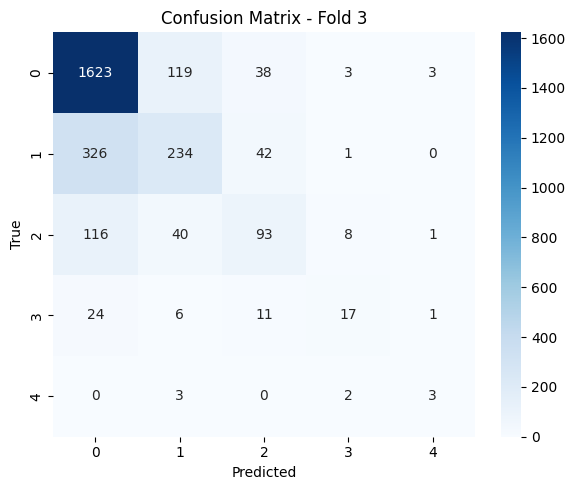

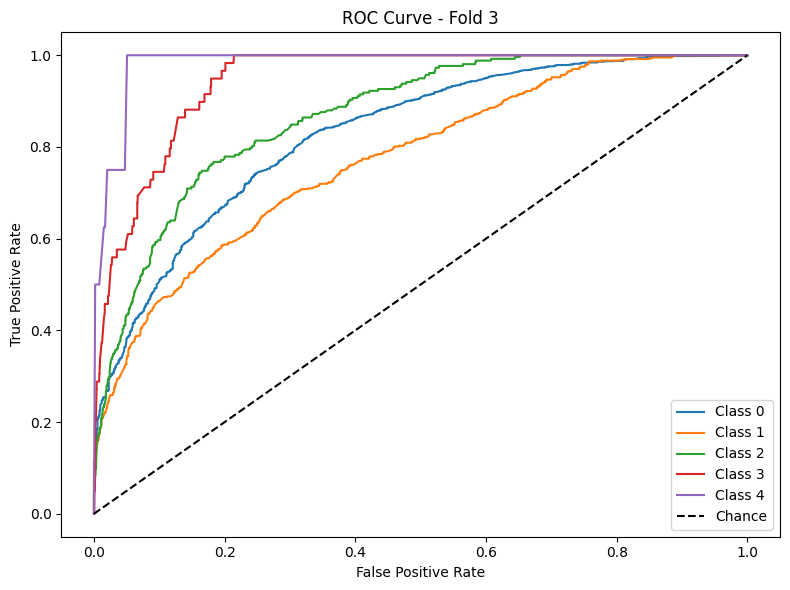


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1785
           1       0.63      0.40      0.49       603
           2       0.59      0.40      0.47       258
           3       0.22      0.10      0.14        59
           4       0.33      0.22      0.27         9

    accuracy                           0.74      2714
   macro avg       0.51      0.41      0.44      2714
weighted avg       0.71      0.74      0.71      2714



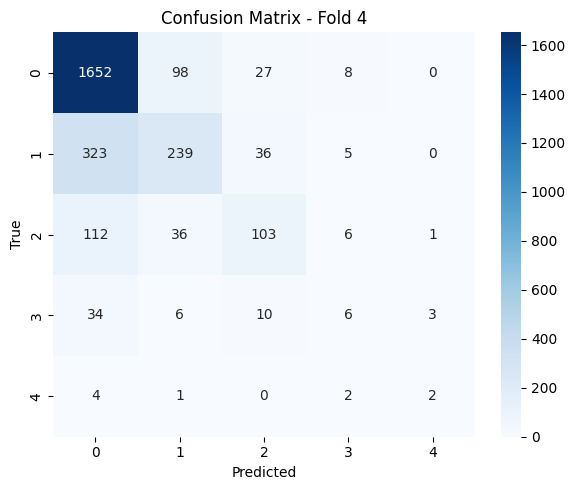

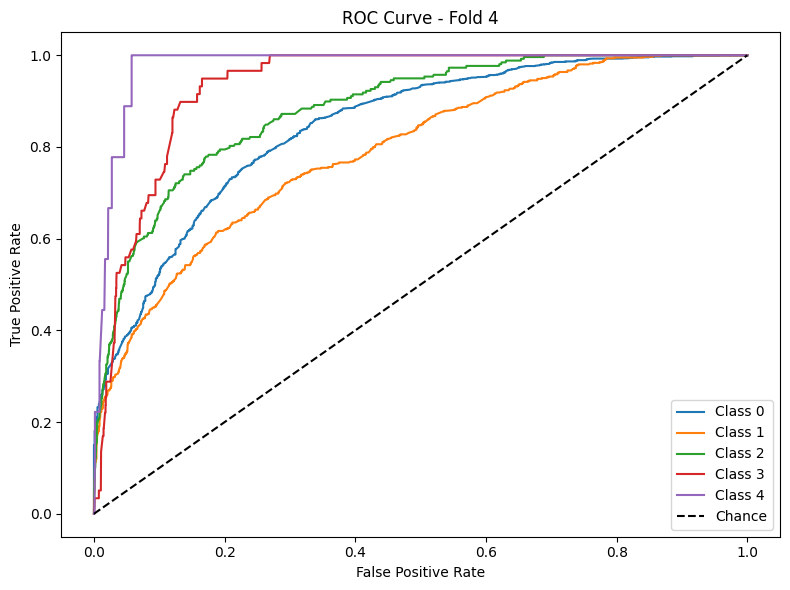


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84      1785
           1       0.60      0.33      0.42       603
           2       0.56      0.38      0.45       258
           3       0.50      0.17      0.25        59
           4       0.75      0.33      0.46         9

    accuracy                           0.73      2714
   macro avg       0.64      0.43      0.49      2714
weighted avg       0.70      0.73      0.70      2714



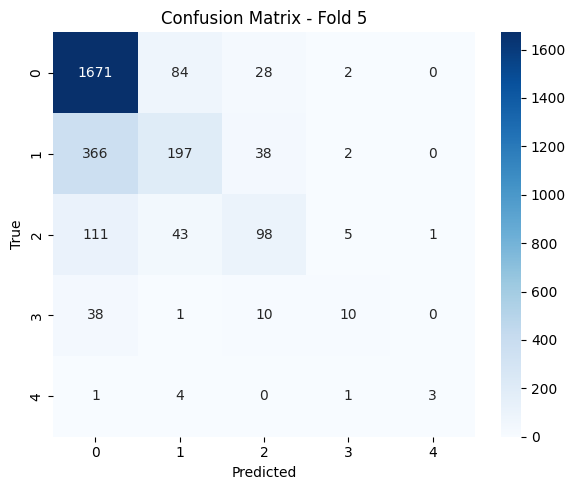

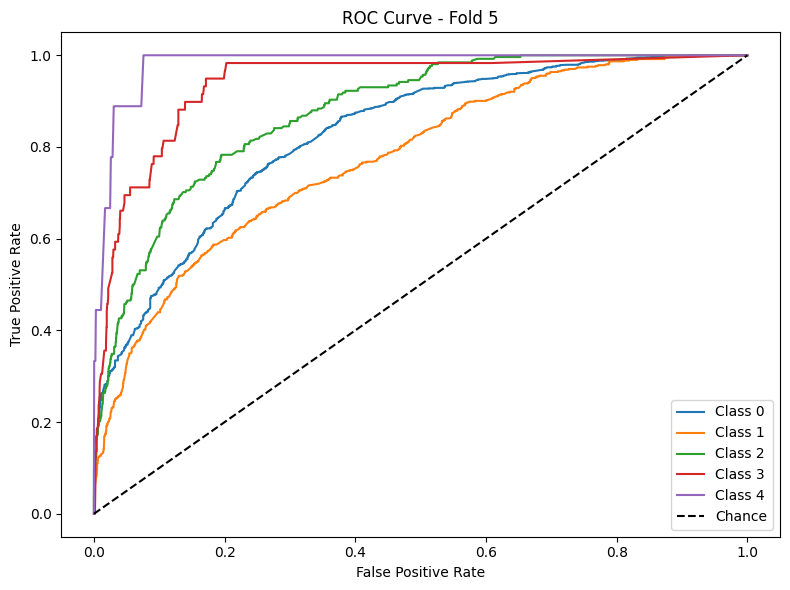


Average Accuracy: 0.7277
Average F1 Macro: 0.4556
Average AUC: 0.8756

Feature Importances:
remaining_time                         0.185053
school                                 0.077967
total_words_phase1                     0.076819
assignment                             0.051977
video                                  0.051491
duration_days                          0.046797
exercise_correct_sum_1                 0.043509
exercise_count                         0.041898
encoded_field_sum                      0.041856
user_month                             0.041320
video_count                            0.038800
total_neutral1                         0.037761
chapter_count                          0.027658
user_time_since_last_course            0.027393
entropy_time_comment_phase1            0.027170
exercise_perc_real_score_mean_1        0.026909
total_positive1                        0.021328
exercise_correct_mean_1                0.021093
user_past_course_count                 0.01

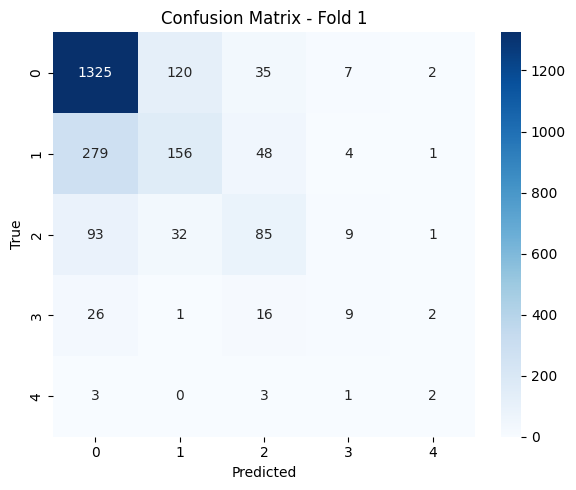

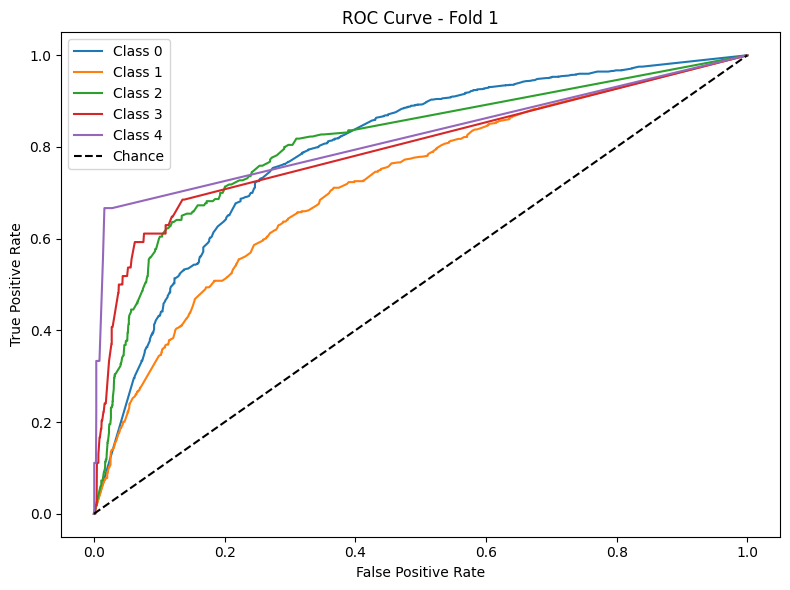


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82      1489
           1       0.50      0.37      0.43       489
           2       0.43      0.36      0.39       219
           3       0.29      0.20      0.24        55
           4       0.33      0.12      0.18         8

    accuracy                           0.70      2260
   macro avg       0.47      0.39      0.41      2260
weighted avg       0.67      0.70      0.68      2260



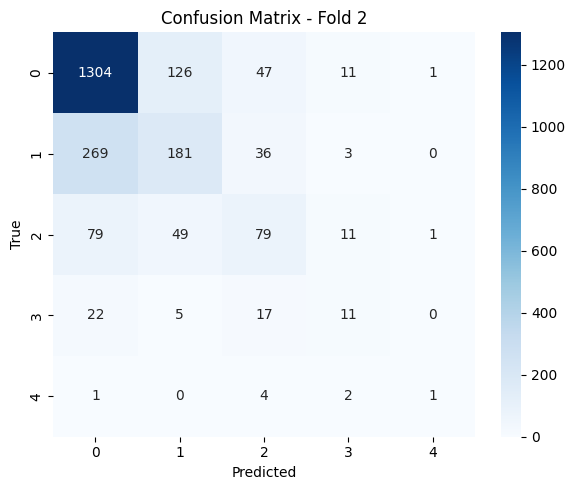

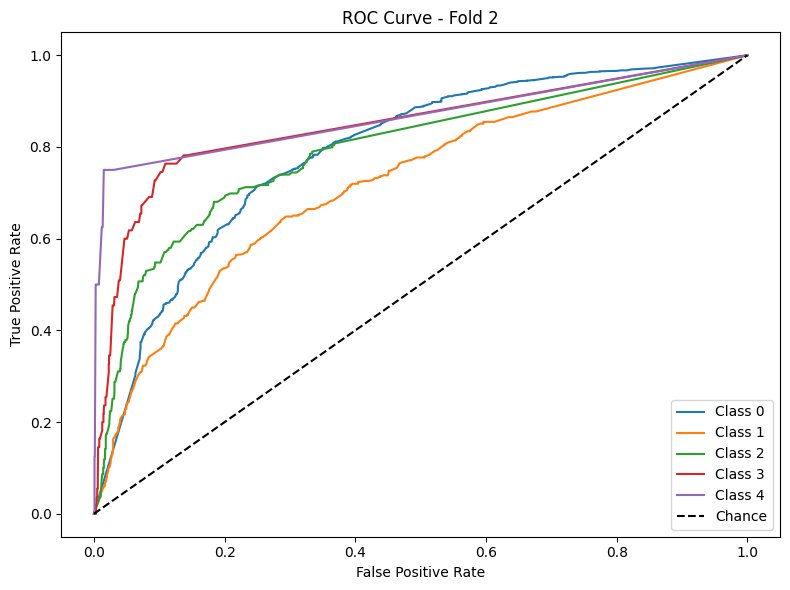


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1489
           1       0.46      0.35      0.39       489
           2       0.47      0.39      0.42       219
           3       0.29      0.19      0.23        54
           4       0.50      0.12      0.20         8

    accuracy                           0.69      2259
   macro avg       0.50      0.38      0.41      2259
weighted avg       0.66      0.69      0.67      2259



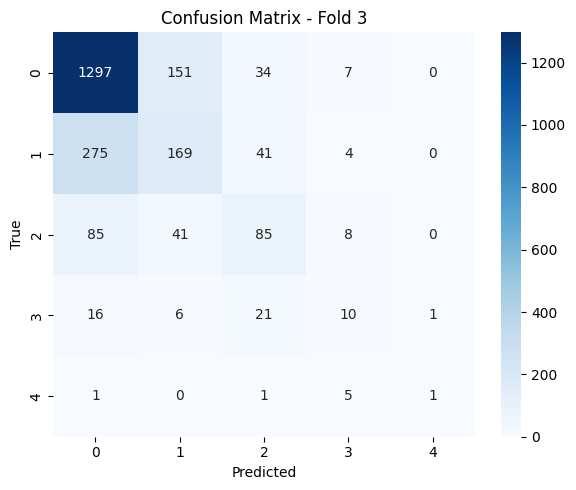

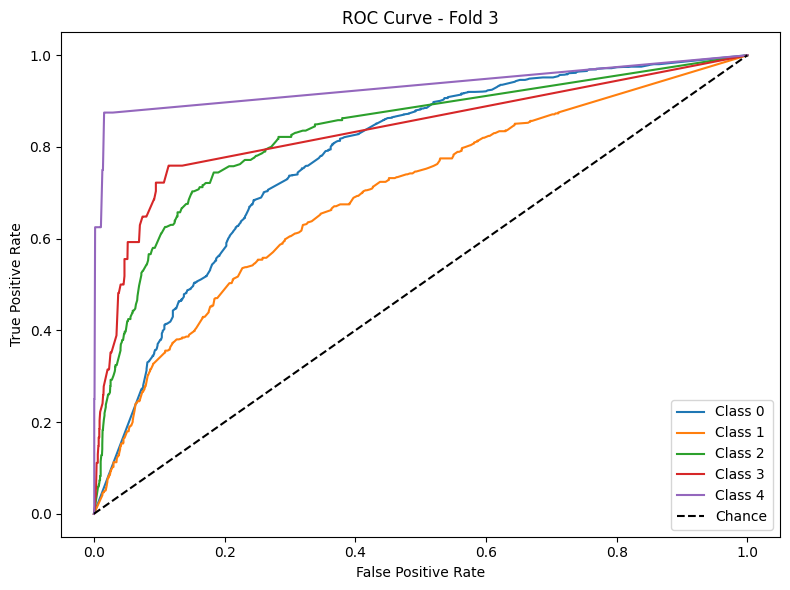


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1489
           1       0.49      0.35      0.41       489
           2       0.45      0.40      0.42       219
           3       0.23      0.13      0.17        54
           4       0.50      0.50      0.50         8

    accuracy                           0.69      2259
   macro avg       0.49      0.45      0.46      2259
weighted avg       0.66      0.69      0.67      2259



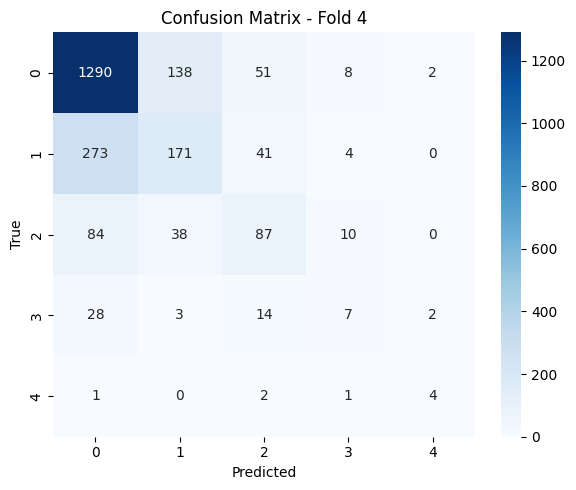

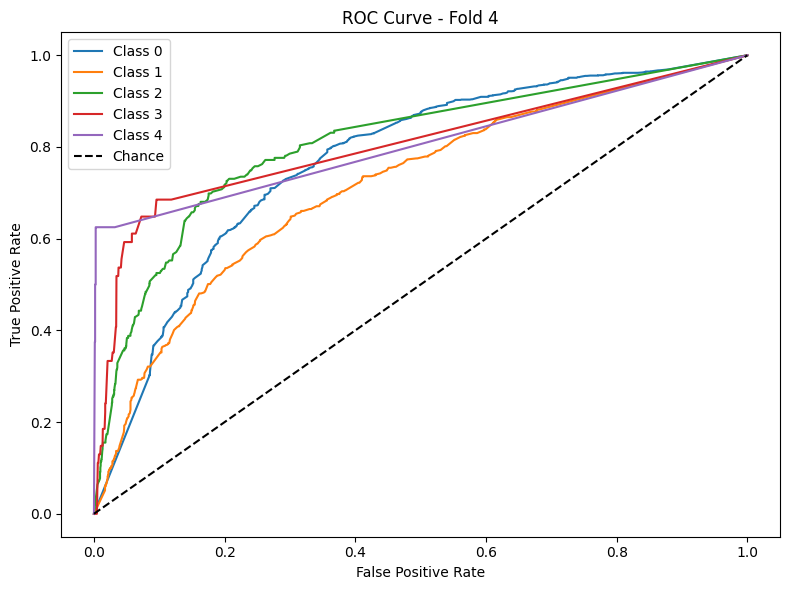


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1490
           1       0.51      0.38      0.43       488
           2       0.45      0.41      0.43       219
           3       0.29      0.15      0.20        54
           4       0.11      0.12      0.12         8

    accuracy                           0.71      2259
   macro avg       0.43      0.39      0.40      2259
weighted avg       0.68      0.71      0.69      2259



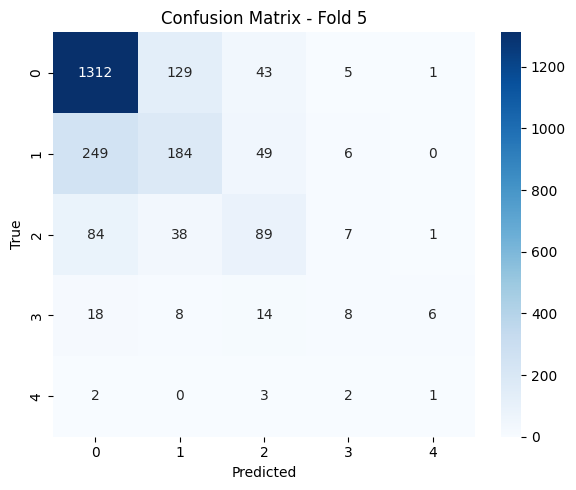

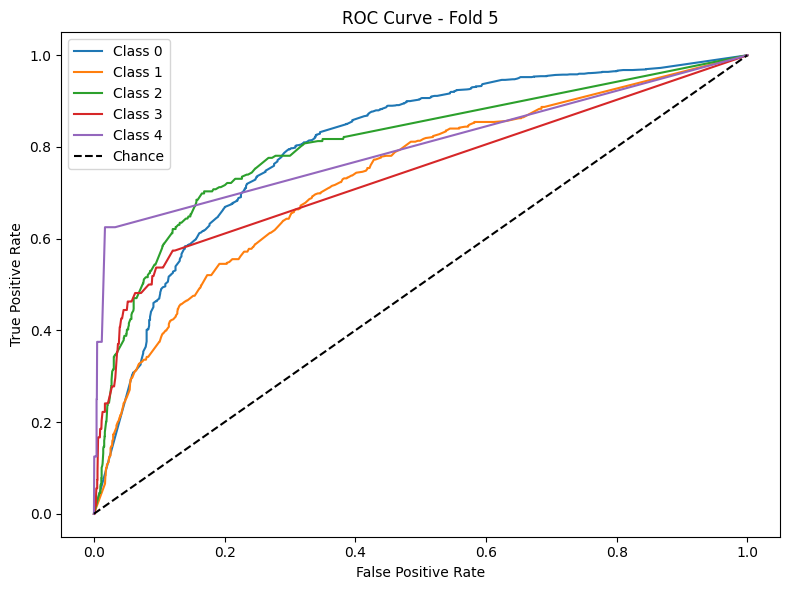


Average Accuracy: 0.6965
Average F1 Macro: 0.4211
Average AUC: 0.7929

Feature Importances:
remaining_time                         0.215813
school                                 0.083155
total_words_phase1                     0.076926
exercise_count                         0.042856
encoded_field_sum                      0.042558
user_month                             0.037803
video_count                            0.037556
duration_days                          0.037465
total_words_phase2                     0.036843
total_neutral1                         0.035842
video                                  0.035361
assignment                             0.035015
user_time_since_last_course            0.030773
chapter_count                          0.024514
entropy_time_comment_phase1            0.021779
total_positive1                        0.019285
total_neutral2                         0.019167
user_past_course_count                 0.015081
num_prerequisites                      0.01

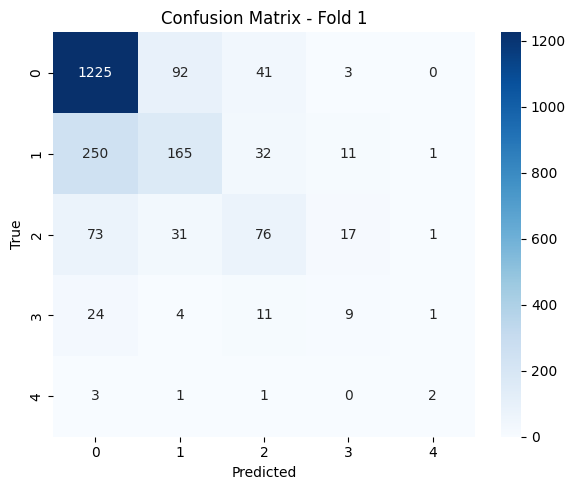

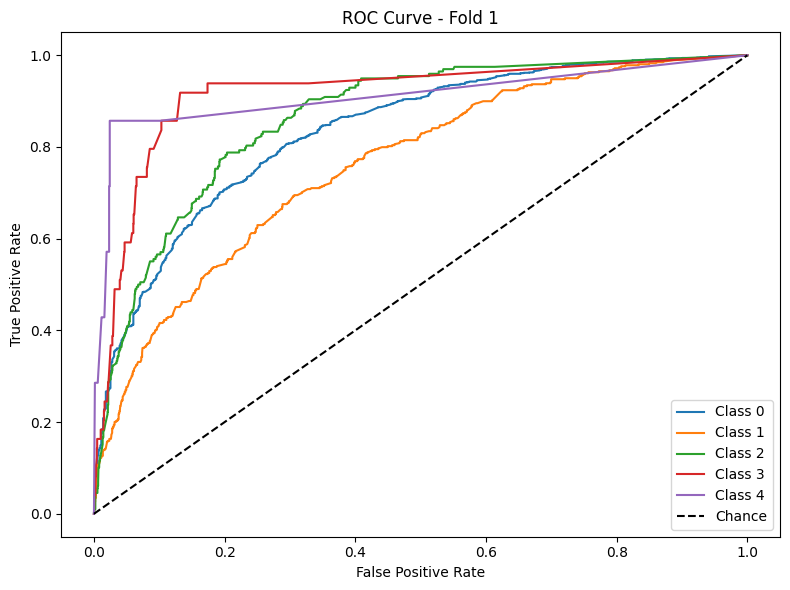


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1360
           1       0.54      0.36      0.43       459
           2       0.51      0.39      0.44       198
           3       0.44      0.16      0.24        50
           4       0.00      0.00      0.00         7

    accuracy                           0.72      2074
   macro avg       0.45      0.36      0.39      2074
weighted avg       0.69      0.72      0.69      2074



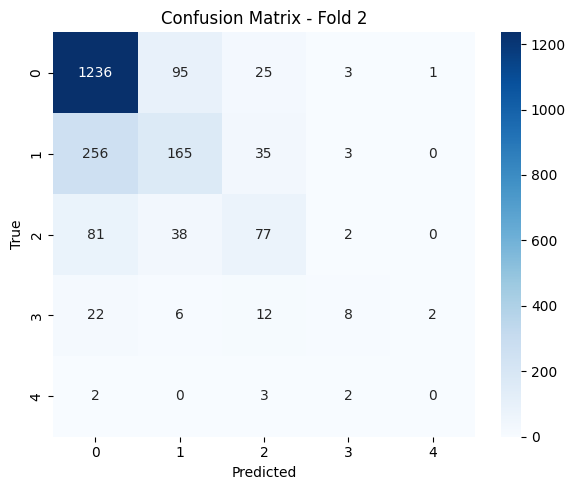

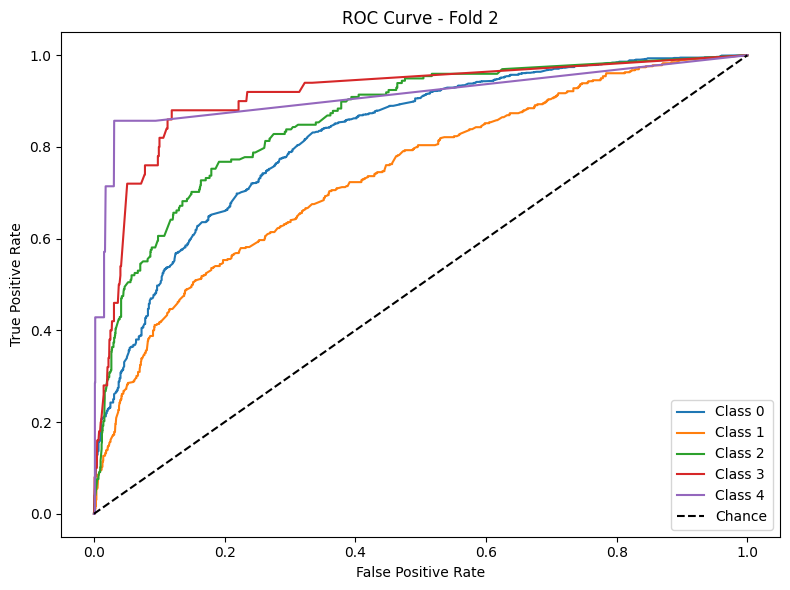


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      1360
           1       0.52      0.35      0.42       459
           2       0.41      0.39      0.40       198
           3       0.41      0.22      0.29        50
           4       0.50      0.14      0.22         7

    accuracy                           0.70      2074
   macro avg       0.52      0.40      0.43      2074
weighted avg       0.68      0.70      0.68      2074



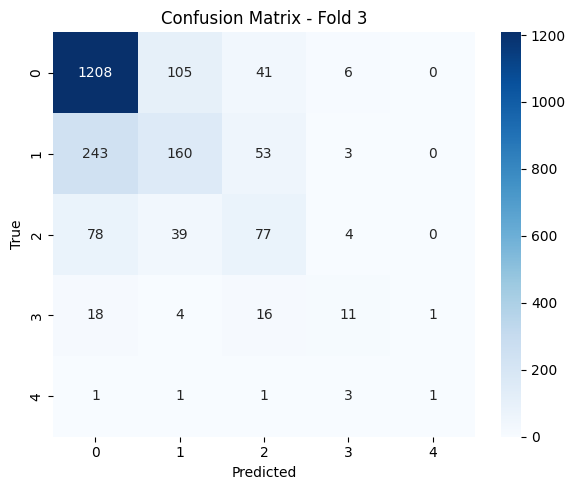

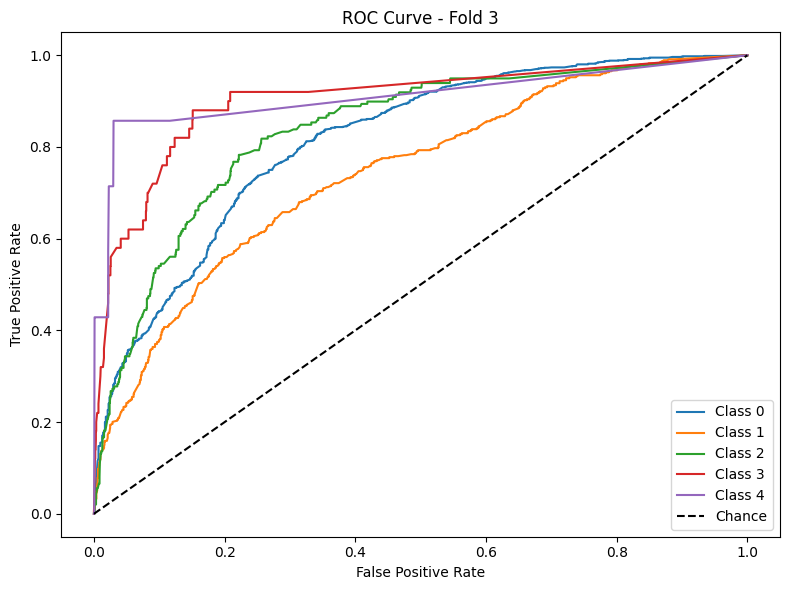


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1360
           1       0.50      0.36      0.42       459
           2       0.51      0.35      0.42       198
           3       0.50      0.22      0.31        50
           4       0.33      0.14      0.20         7

    accuracy                           0.70      2074
   macro avg       0.52      0.39      0.43      2074
weighted avg       0.67      0.70      0.68      2074



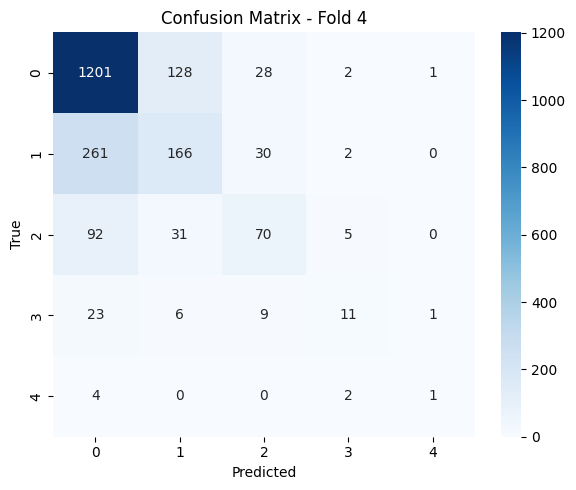

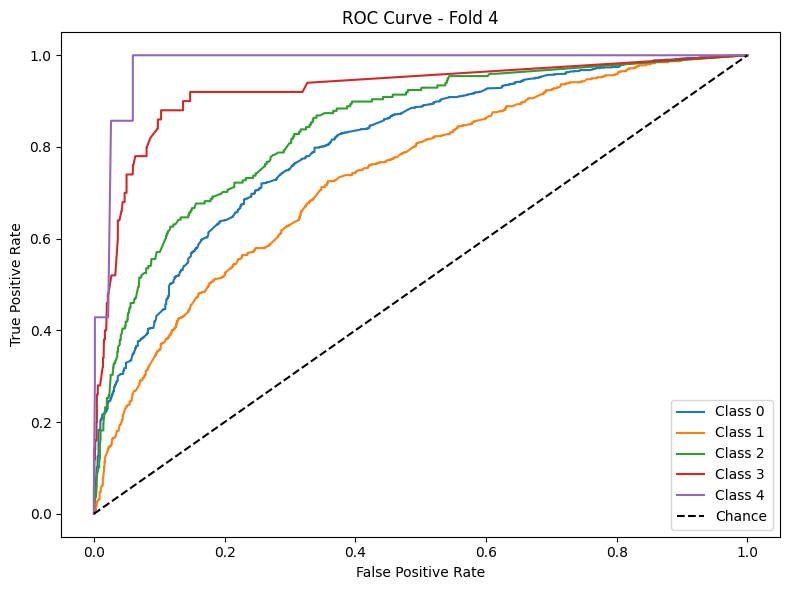


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      1360
           1       0.50      0.35      0.41       460
           2       0.49      0.42      0.45       197
           3       0.41      0.22      0.29        49
           4       0.20      0.14      0.17         7

    accuracy                           0.70      2073
   macro avg       0.47      0.40      0.43      2073
weighted avg       0.68      0.70      0.68      2073



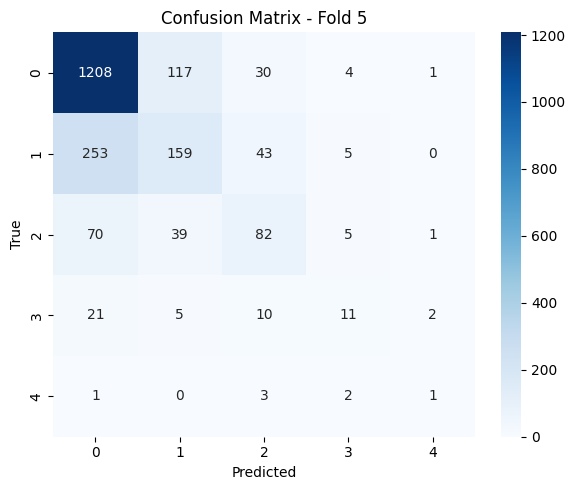

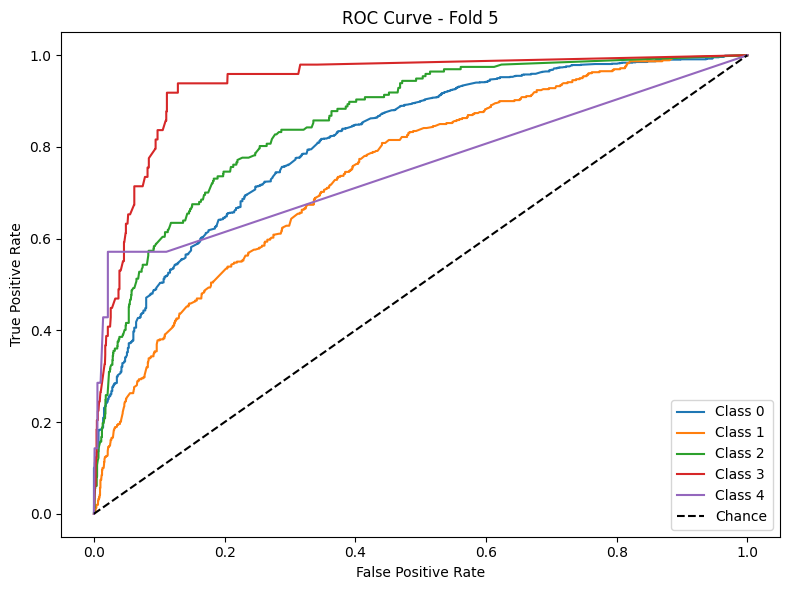


Average Accuracy: 0.7069
Average F1 Macro: 0.4253
Average AUC: 0.8453

Feature Importances:
remaining_time                         0.158166
school                                 0.070405
video                                  0.052388
encoded_field_sum                      0.051347
video_count                            0.049402
duration_days                          0.049357
exercise_count                         0.048428
assignment                             0.045362
total_words_phase1                     0.043889
user_month                             0.037320
chapter_count                          0.034064
total_neutral1                         0.026291
total_words_phase3                     0.026122
total_words_phase2                     0.024283
user_time_since_last_course            0.021613
total_neutral3                         0.018311
num_prerequisites                      0.016878
entropy_time_comment_phase1            0.015765
total_positive1                        0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1000
           1       0.60      0.35      0.45       355
           2       0.40      0.29      0.33       139
           3       0.41      0.28      0.33        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1539
   macro avg       0.44      0.37      0.39      1539
weighted avg       0.69      0.72      0.69      1539



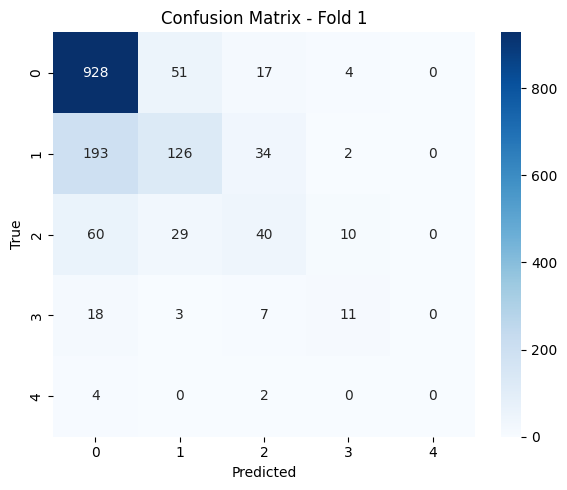

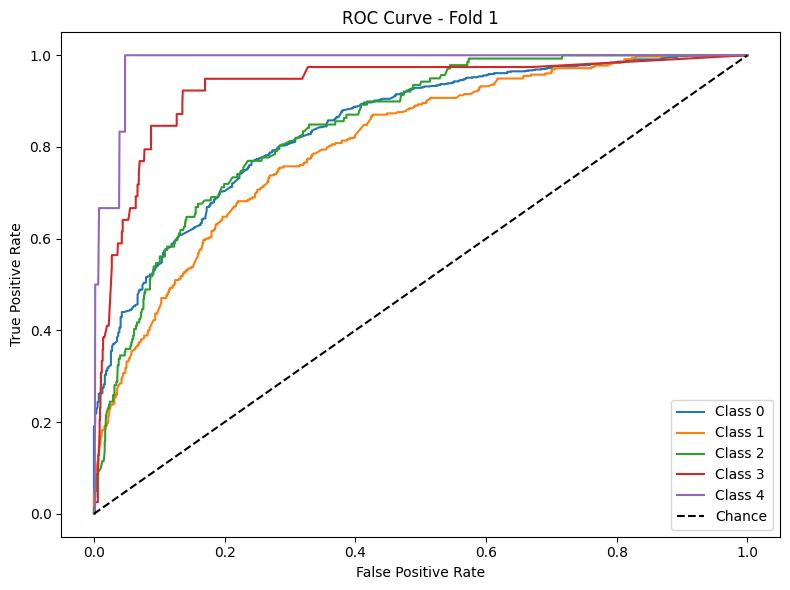


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1000
           1       0.59      0.39      0.47       355
           2       0.60      0.42      0.50       139
           3       0.57      0.20      0.30        40
           4       0.00      0.00      0.00         5

    accuracy                           0.73      1539
   macro avg       0.51      0.39      0.42      1539
weighted avg       0.71      0.73      0.71      1539



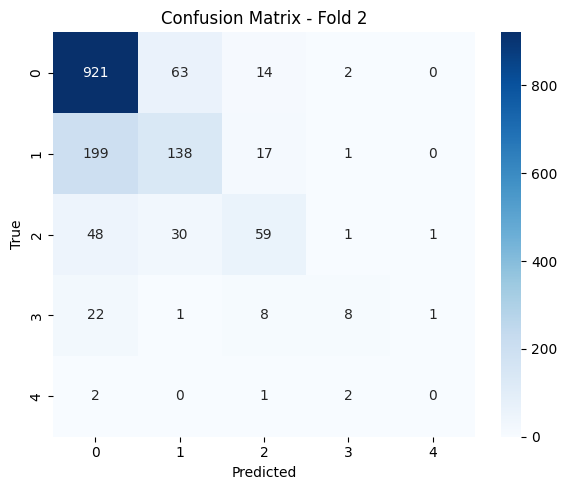

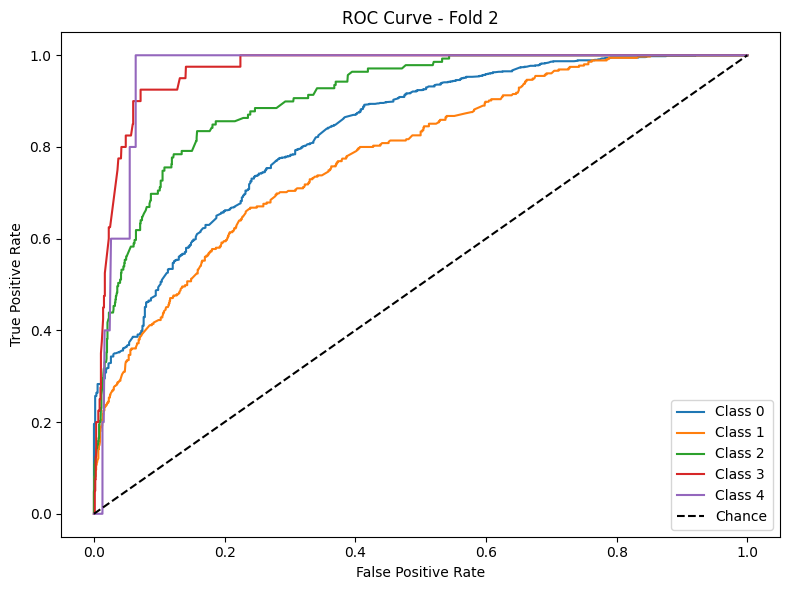


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       999
           1       0.62      0.41      0.49       355
           2       0.55      0.34      0.42       139
           3       0.43      0.23      0.30        40
           4       0.33      0.17      0.22         6

    accuracy                           0.74      1539
   macro avg       0.54      0.41      0.46      1539
weighted avg       0.71      0.74      0.71      1539



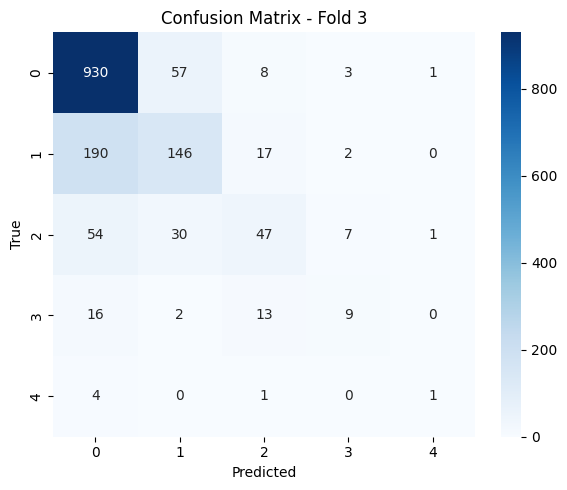

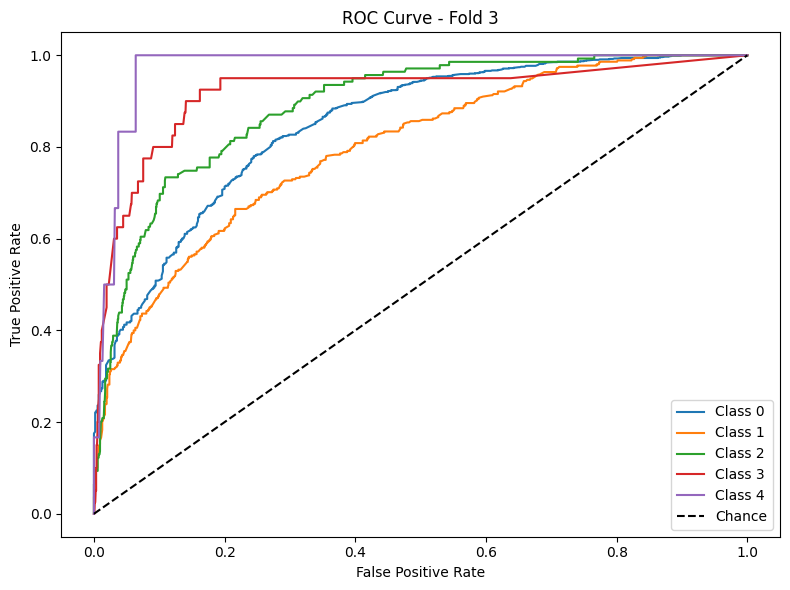

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       999
           1       0.63      0.37      0.46       356
           2       0.49      0.32      0.39       138
           3       0.25      0.13      0.17        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.43      0.35      0.37      1538
weighted avg       0.70      0.73      0.70      1538



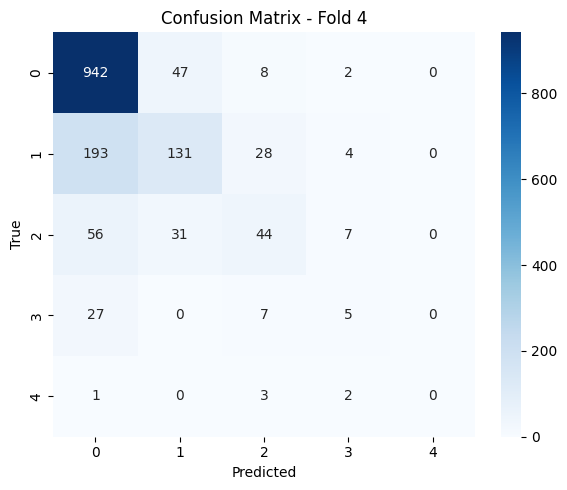

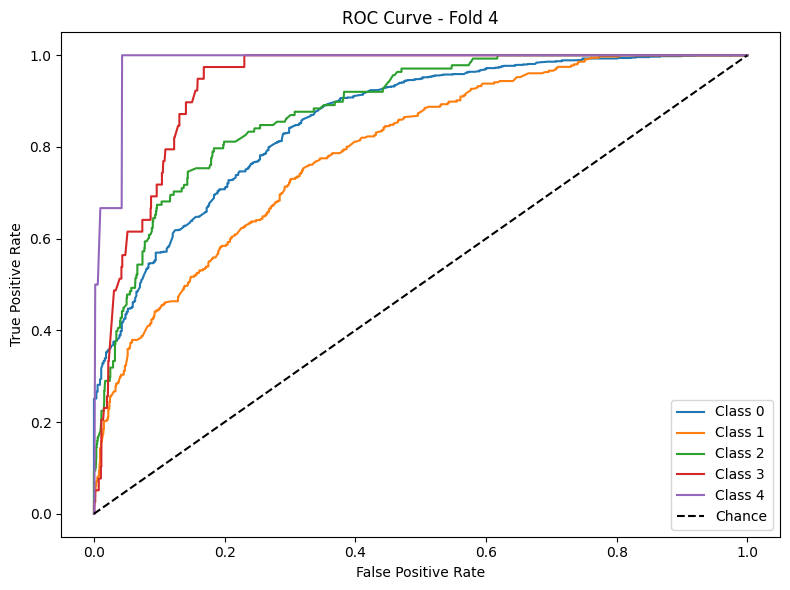

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.84       999
           1       0.61      0.38      0.47       356
           2       0.47      0.33      0.39       138
           3       0.48      0.28      0.35        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.47      0.38      0.41      1538
weighted avg       0.70      0.73      0.70      1538



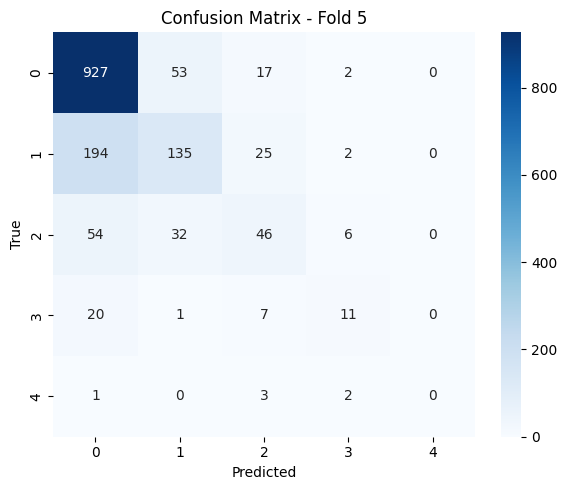

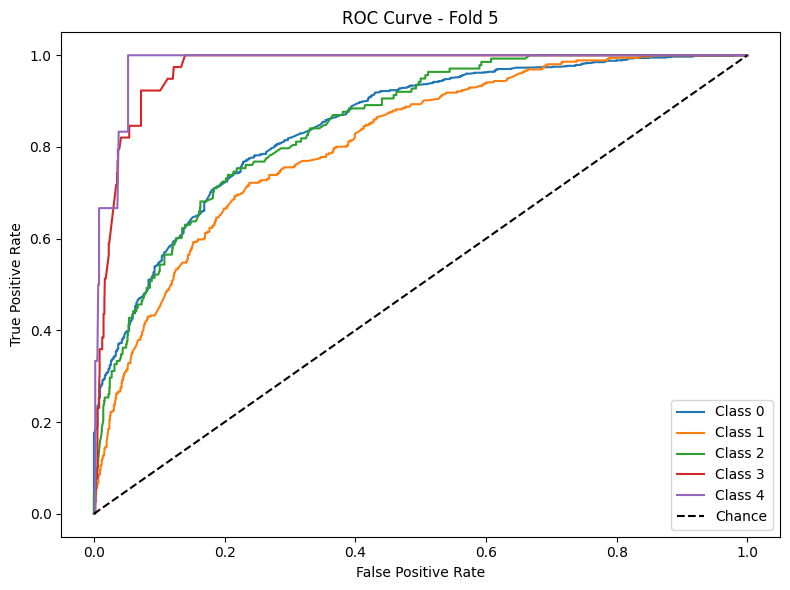


Average Accuracy: 0.7286
Average F1 Macro: 0.4106
Average AUC: 0.8881

Feature Importances:
remaining_time                         0.083049
school                                 0.058783
assignment                             0.054843
duration_days                          0.052171
video_count                            0.051823
encoded_field_sum                      0.049103
video                                  0.047412
exercise_count                         0.046862
chapter_count                          0.038086
user_month                             0.032893
total_words_phase1                     0.030324
exercise_correct_sum_4                 0.026495
total_words_phase4                     0.019598
user_time_since_last_course            0.017611
total_neutral1                         0.016568
exercise_context_sum_4                 0.016025
num_prerequisites                      0.015772
total_words_phase2                     0.015418
total_words_phase3                     0.01

In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       568
           1       0.52      0.21      0.30        63
           2       0.47      0.21      0.29        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.84       698
   macro avg       0.37      0.28      0.30       698
weighted avg       0.77      0.84      0.79       698



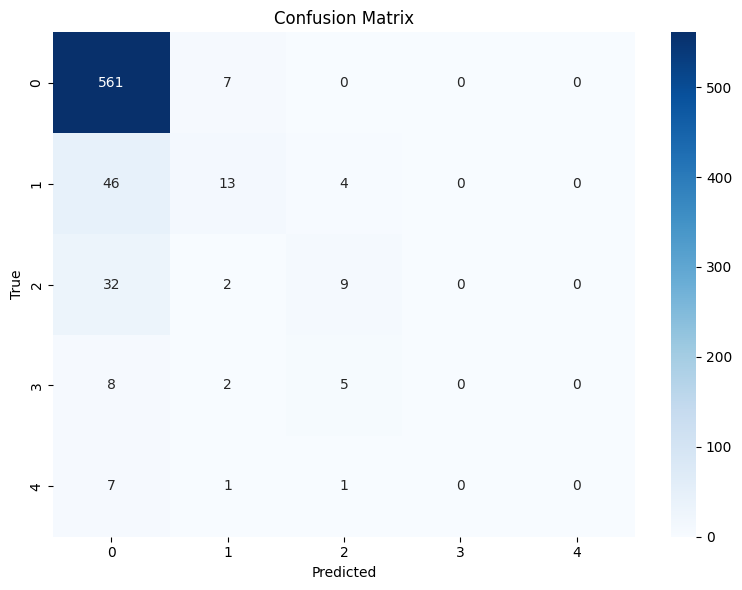


Test AUC (macro-average, OVR): 0.8476


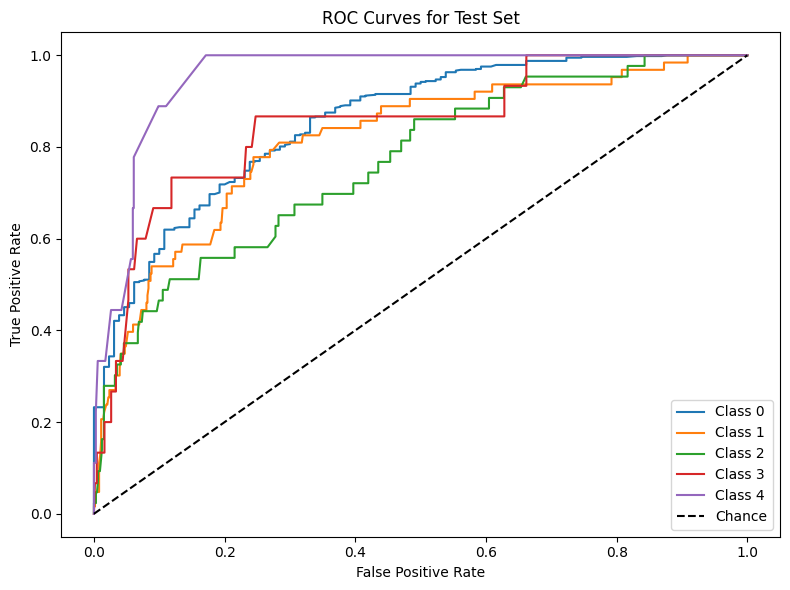

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       544
           1       0.22      0.03      0.06        59
           2       0.33      0.07      0.12        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.28      0.22      0.22       668
weighted avg       0.72      0.81      0.75       668



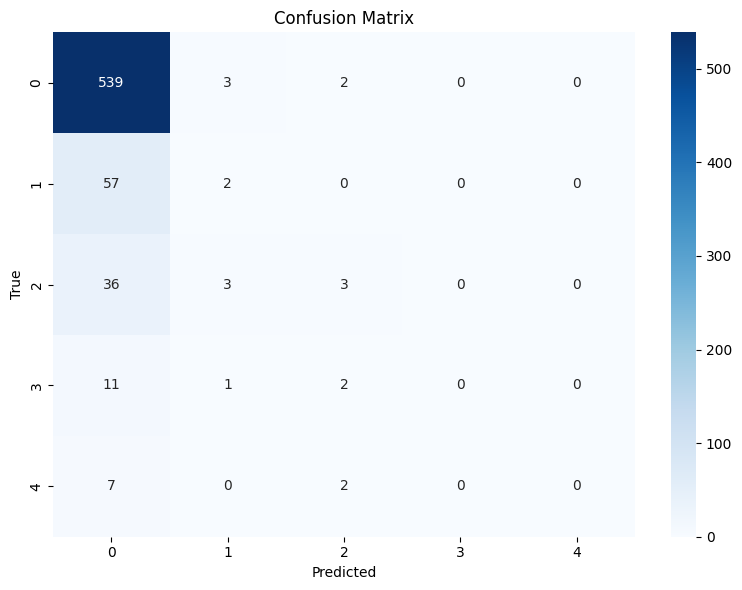


Test AUC (macro-average, OVR): 0.8068


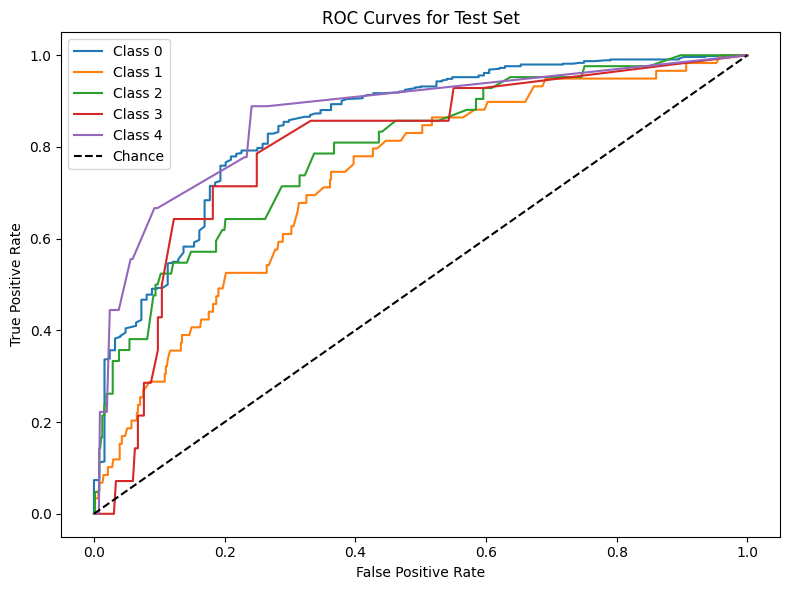

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       455
           1       0.33      0.04      0.07        52
           2       0.50      0.03      0.06        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.33      0.21      0.21       554
weighted avg       0.74      0.82      0.75       554



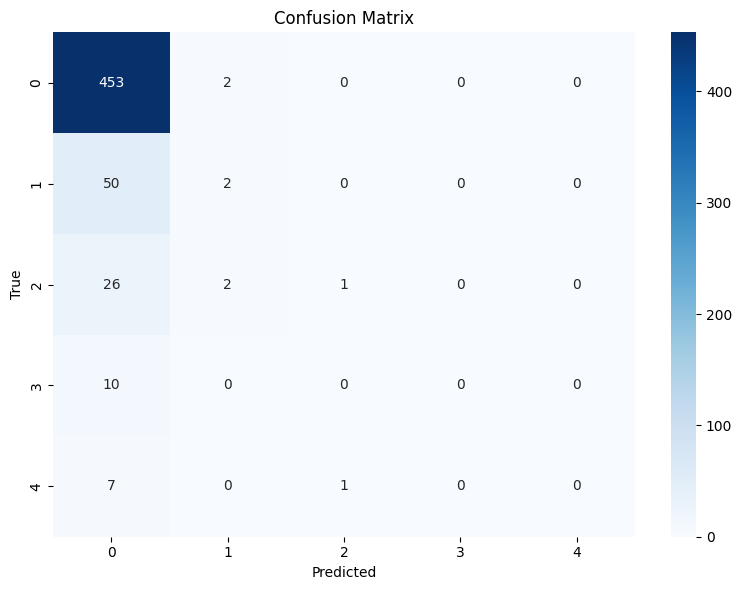


Test AUC (macro-average, OVR): 0.8154


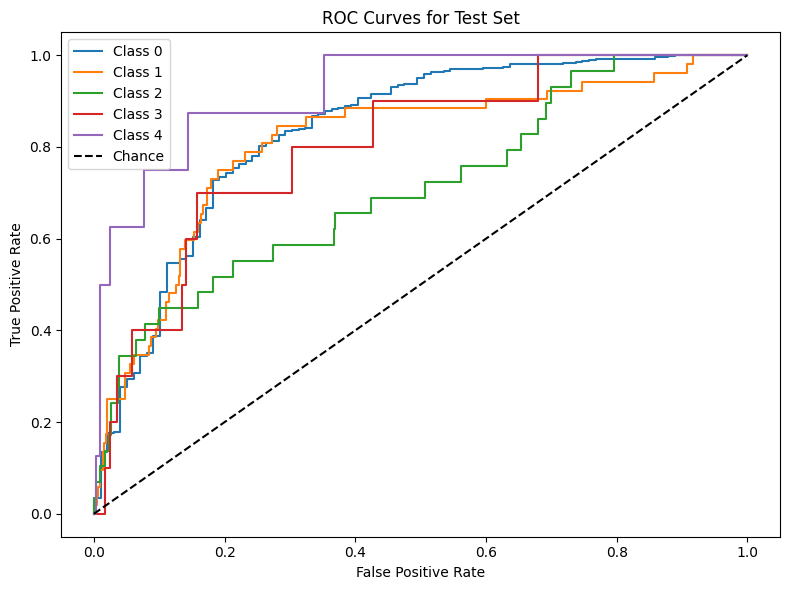

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       395
           1       0.25      0.03      0.05        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       477
   macro avg       0.22      0.20      0.19       477
weighted avg       0.71      0.83      0.76       477



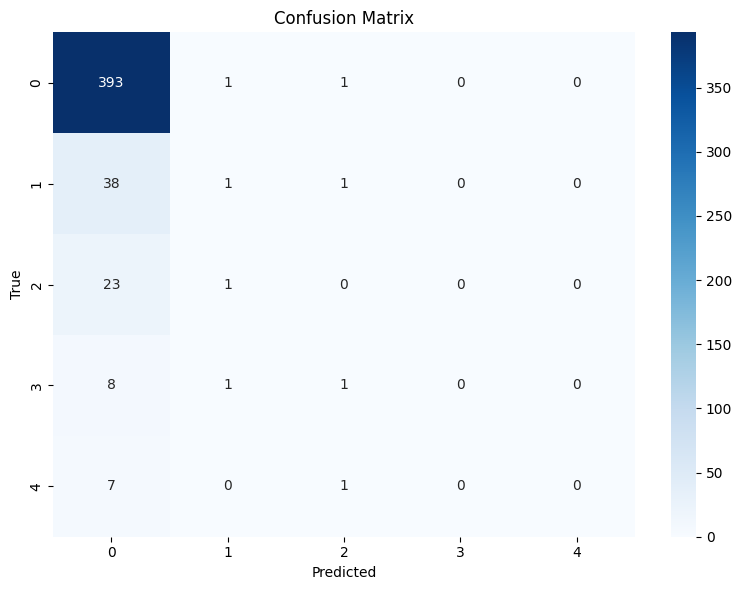


Test AUC (macro-average, OVR): 0.7799


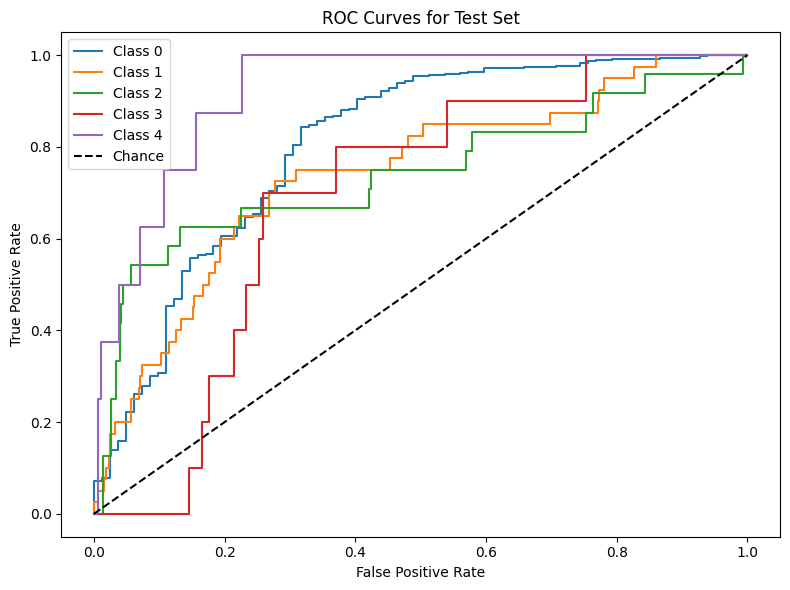

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Add SMOTE Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1785
           1       0.54      0.48      0.51       604
           2       0.40      0.51      0.45       258
           3       0.23      0.44      0.30        59
           4       0.07      0.11      0.09         9

    accuracy                           0.69      2715
   macro avg       0.41      0.47      0.43      2715
weighted avg       0.71      0.69      0.70      2715



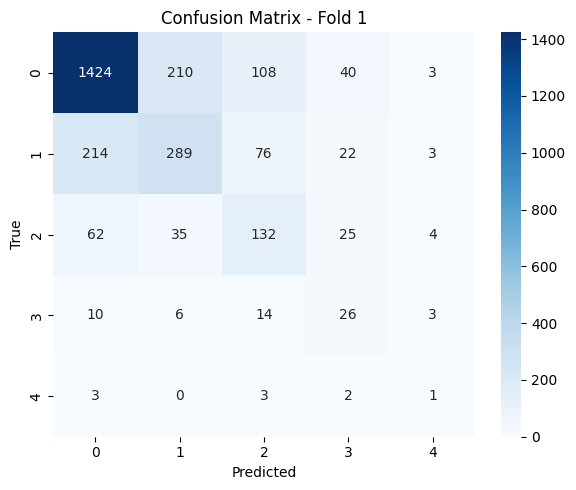

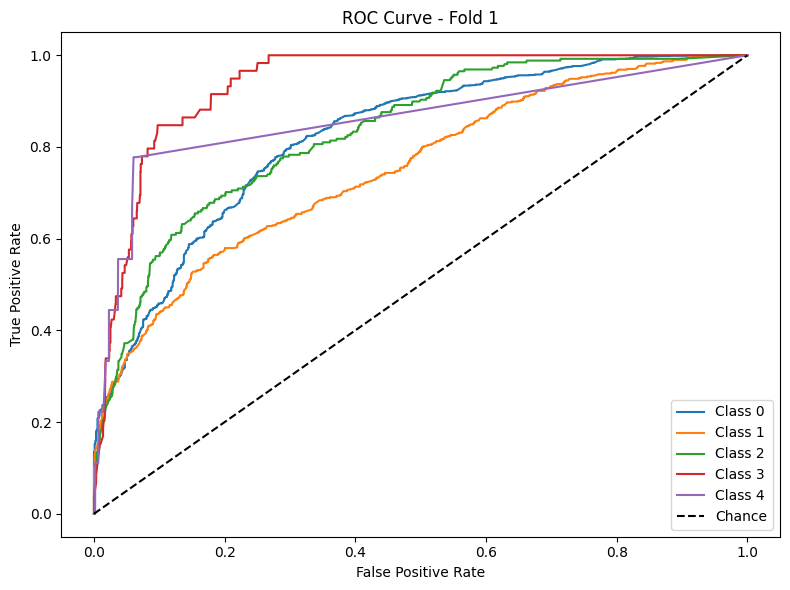


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      1786
           1       0.50      0.47      0.49       603
           2       0.41      0.52      0.46       258
           3       0.22      0.51      0.31        59
           4       0.09      0.12      0.11         8

    accuracy                           0.67      2714
   macro avg       0.41      0.48      0.43      2714
weighted avg       0.70      0.67      0.68      2714



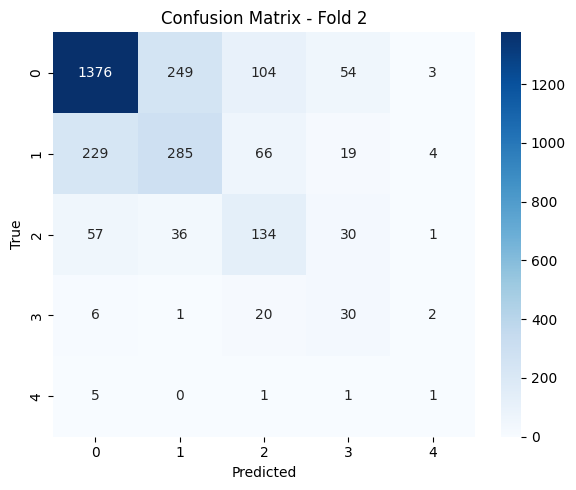

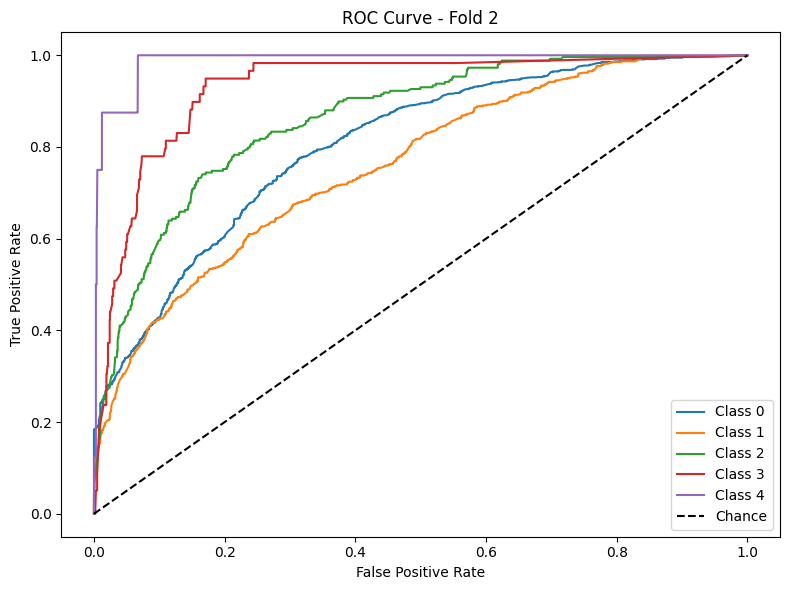


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.79      1786
           1       0.49      0.49      0.49       603
           2       0.41      0.56      0.47       258
           3       0.27      0.42      0.33        59
           4       0.30      0.38      0.33         8

    accuracy                           0.68      2714
   macro avg       0.46      0.52      0.48      2714
weighted avg       0.70      0.68      0.68      2714



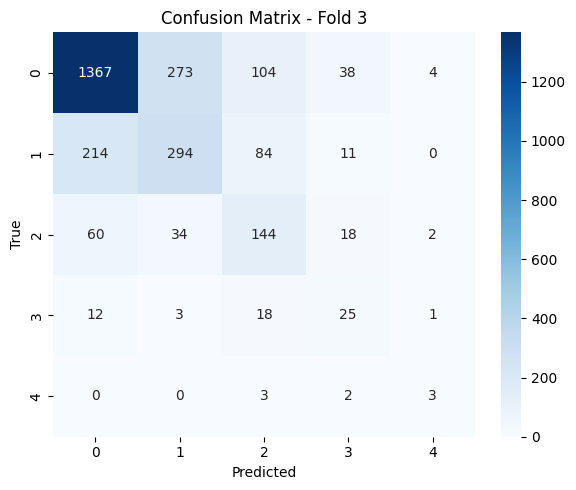

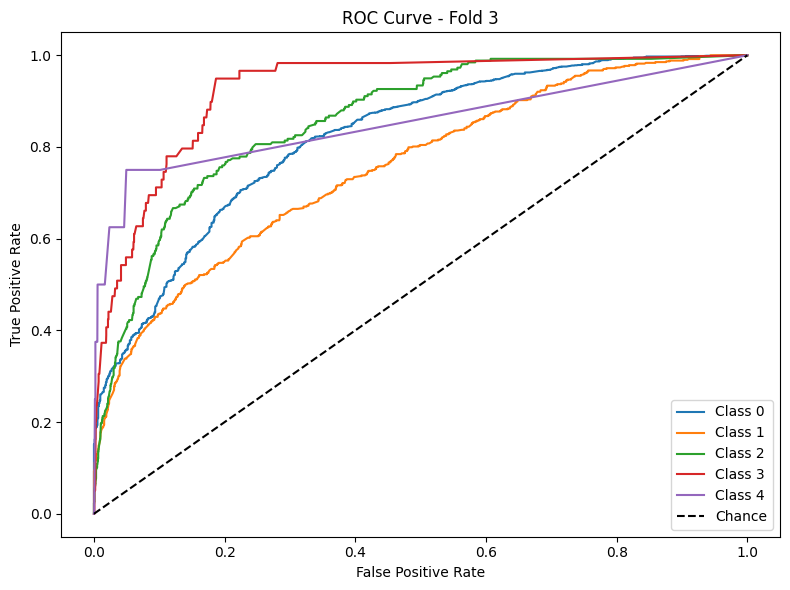


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81      1785
           1       0.50      0.52      0.51       603
           2       0.42      0.55      0.48       258
           3       0.20      0.27      0.23        59
           4       0.18      0.22      0.20         9

    accuracy                           0.69      2714
   macro avg       0.43      0.47      0.45      2714
weighted avg       0.71      0.69      0.70      2714



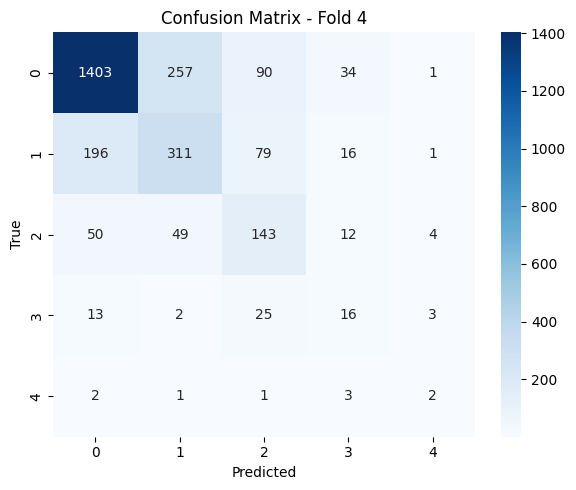

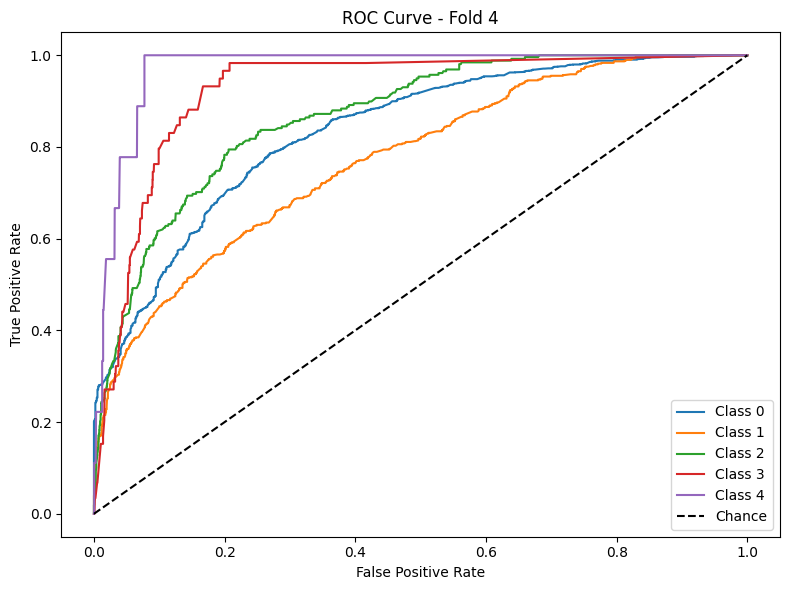


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1785
           1       0.54      0.50      0.52       603
           2       0.44      0.50      0.47       258
           3       0.19      0.42      0.26        59
           4       0.33      0.33      0.33         9

    accuracy                           0.69      2714
   macro avg       0.47      0.51      0.48      2714
weighted avg       0.71      0.69      0.70      2714



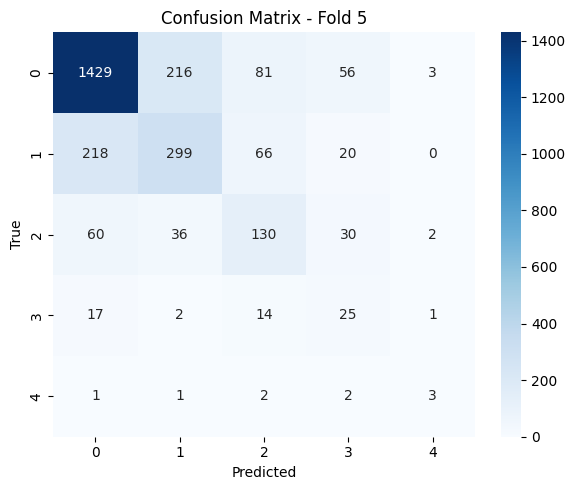

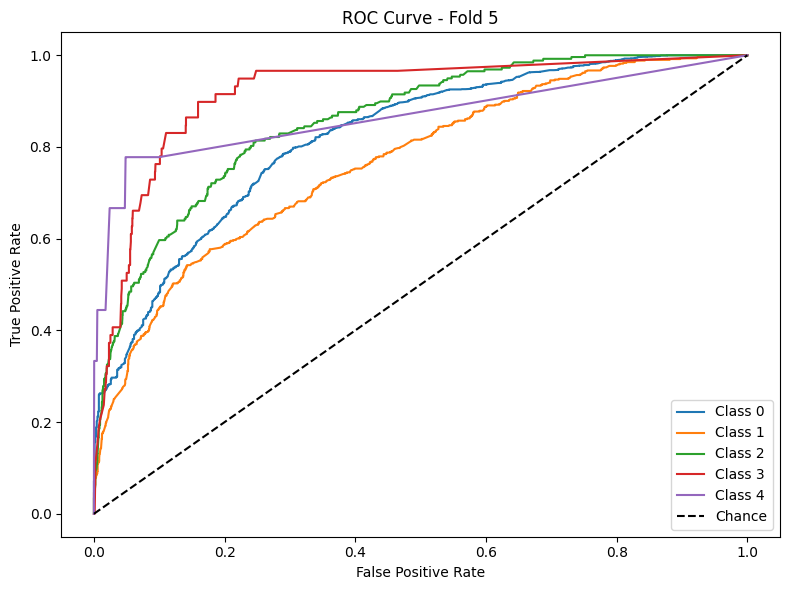


Average Accuracy: 0.6847
Average F1 Macro: 0.4540
Average AUC: 0.8546

Feature Importances:
remaining_time                         0.150162
assignment                             0.102083
video                                  0.101683
school                                 0.079566
encoded_field_sum                      0.073178
user_month                             0.071439
video_count                            0.061131
duration_days                          0.052317
exercise_count                         0.052163
chapter_count                          0.049185
total_words_phase1                     0.031244
total_neutral1                         0.021666
exercise_correct_sum_1                 0.018622
exercise_perc_real_score_mean_1        0.018366
num_prerequisites                      0.016334
exercise_correct_mean_1                0.011393
user_past_course_count                 0.010468
total_positive1                        0.008892
entropy_time_comment_phase1            0.00

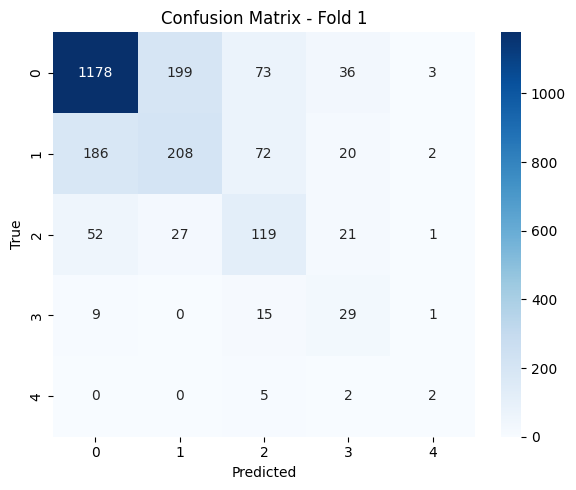

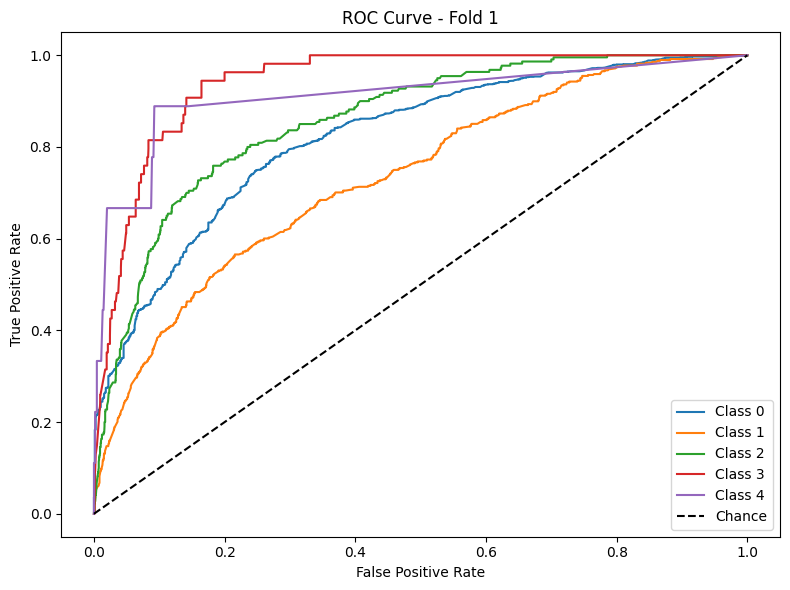


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      1489
           1       0.46      0.47      0.47       489
           2       0.36      0.46      0.41       219
           3       0.23      0.47      0.31        55
           4       0.20      0.38      0.26         8

    accuracy                           0.66      2260
   macro avg       0.42      0.51      0.45      2260
weighted avg       0.69      0.66      0.67      2260



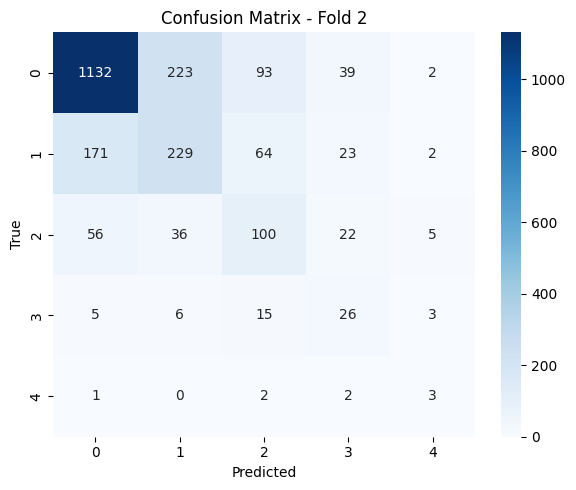

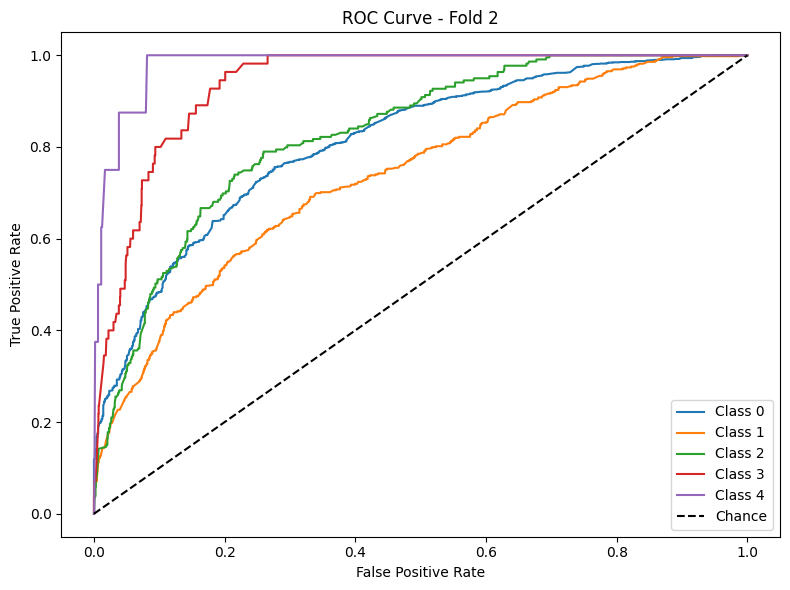


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1489
           1       0.47      0.45      0.46       489
           2       0.42      0.52      0.47       219
           3       0.21      0.41      0.28        54
           4       0.50      0.50      0.50         8

    accuracy                           0.68      2259
   macro avg       0.49      0.53      0.50      2259
weighted avg       0.70      0.68      0.69      2259



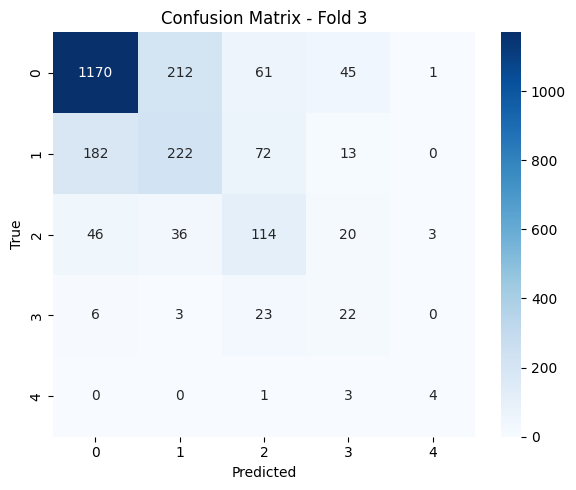

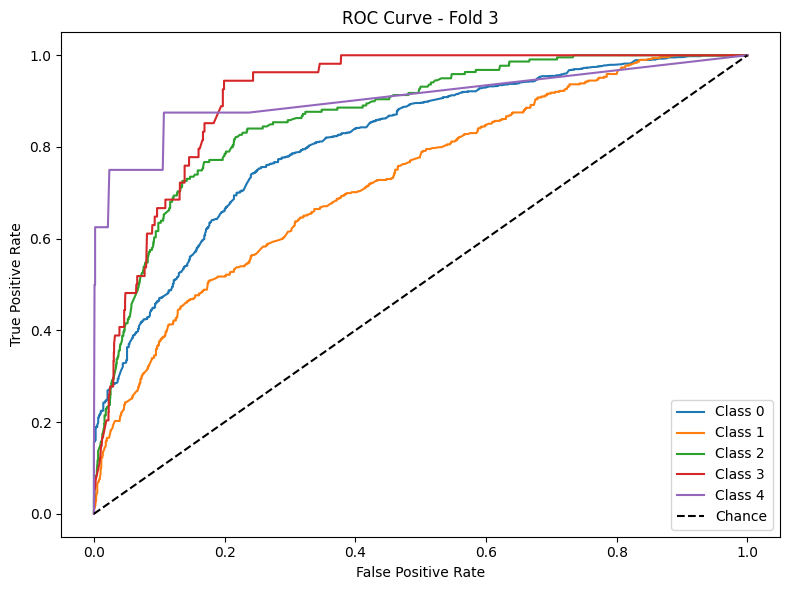


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1489
           1       0.48      0.45      0.47       489
           2       0.42      0.52      0.47       219
           3       0.24      0.43      0.31        54
           4       0.31      0.50      0.38         8

    accuracy                           0.68      2259
   macro avg       0.46      0.54      0.49      2259
weighted avg       0.69      0.68      0.68      2259



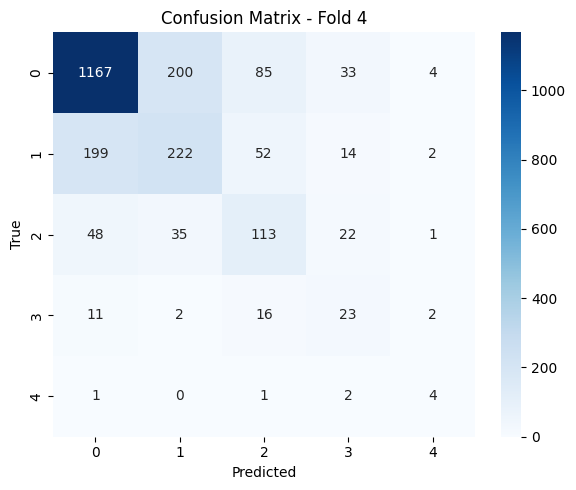

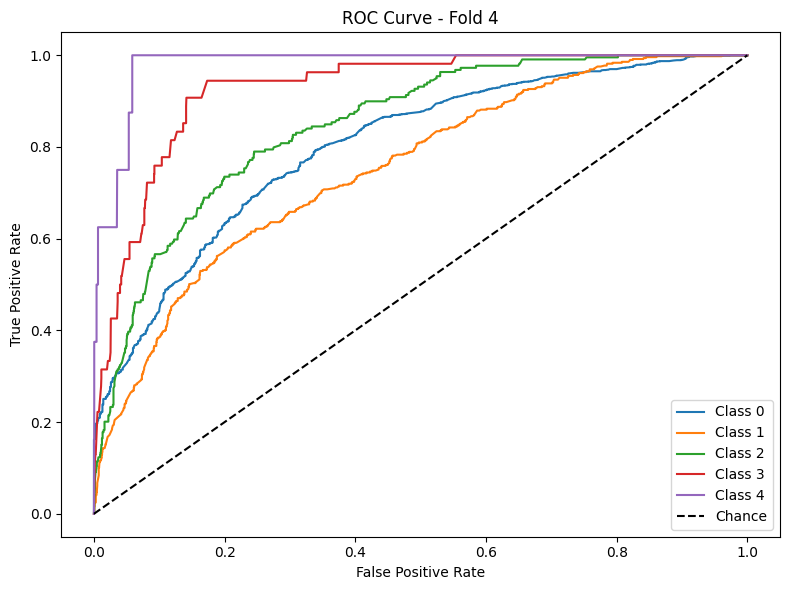


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1490
           1       0.49      0.49      0.49       488
           2       0.38      0.52      0.44       219
           3       0.17      0.26      0.21        54
           4       0.08      0.12      0.10         8

    accuracy                           0.68      2259
   macro avg       0.39      0.43      0.41      2259
weighted avg       0.70      0.68      0.69      2259



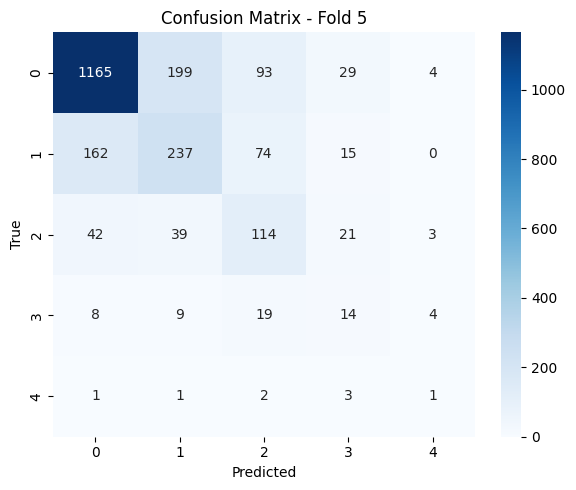

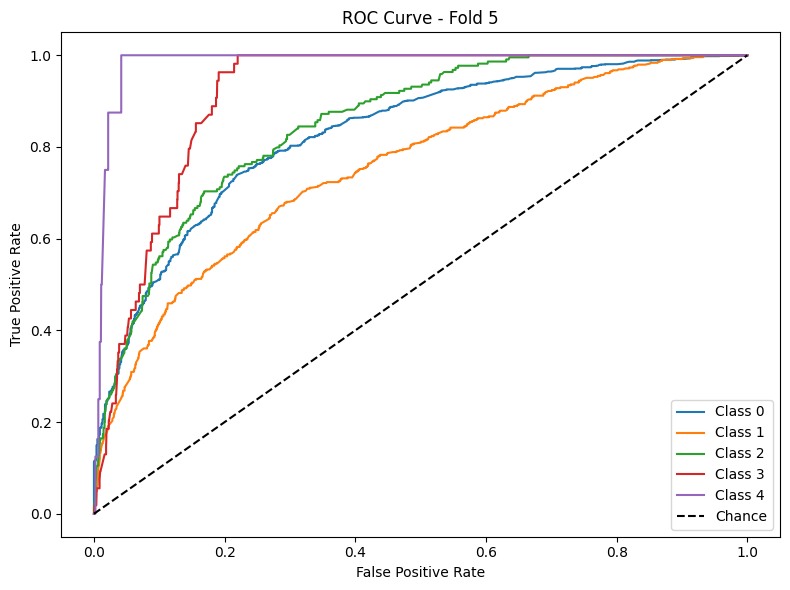


Average Accuracy: 0.6743
Average F1 Macro: 0.4614
Average AUC: 0.8571

Feature Importances:
remaining_time                         0.127702
assignment                             0.106634
video                                  0.090762
encoded_field_sum                      0.077378
user_month                             0.070557
video_count                            0.068594
school                                 0.065500
exercise_count                         0.060467
chapter_count                          0.052981
duration_days                          0.051761
total_words_phase1                     0.024842
num_prerequisites                      0.024374
total_neutral1                         0.016710
certificate                            0.014994
user_past_course_count                 0.014391
exam                                   0.014098
total_words_phase2                     0.012112
total_positive1                        0.009194
total_neutral2                         0.00

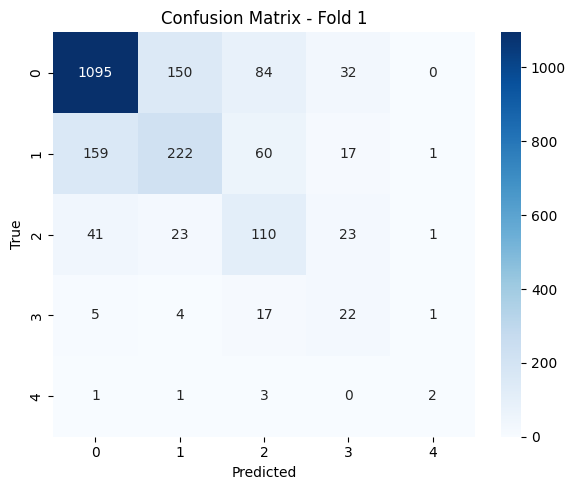

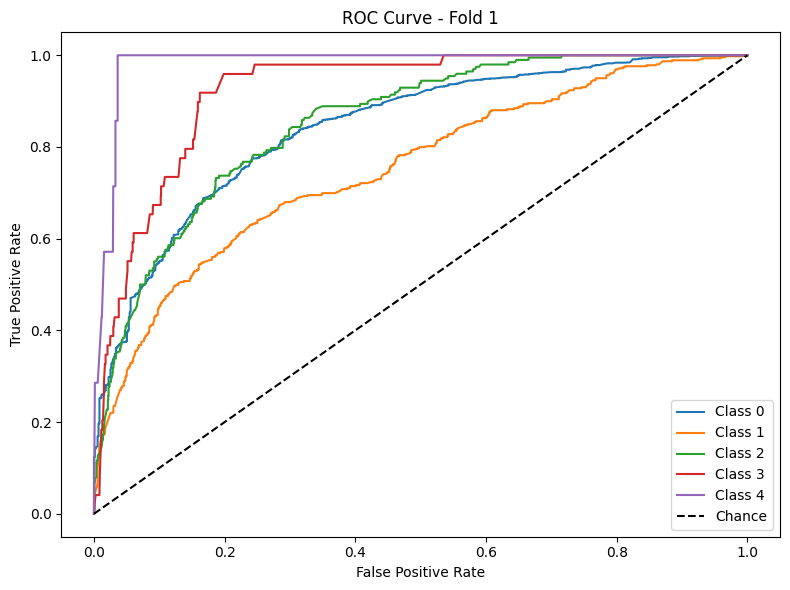


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1360
           1       0.49      0.46      0.47       459
           2       0.44      0.53      0.48       198
           3       0.23      0.52      0.32        50
           4       0.20      0.14      0.17         7

    accuracy                           0.68      2074
   macro avg       0.44      0.49      0.45      2074
weighted avg       0.70      0.68      0.69      2074



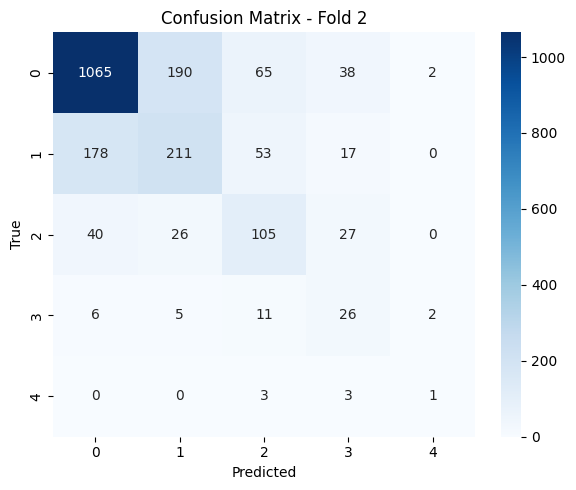

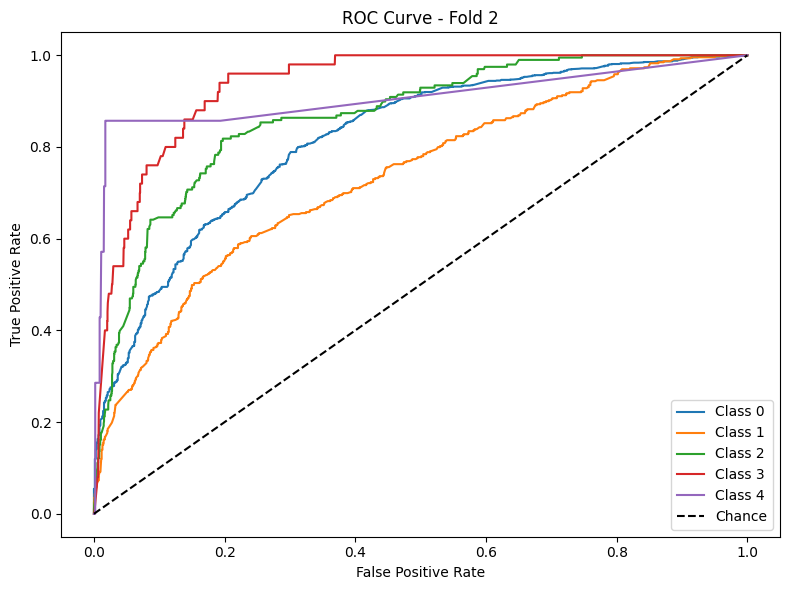


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1360
           1       0.47      0.45      0.46       459
           2       0.35      0.45      0.40       198
           3       0.22      0.40      0.29        50
           4       0.22      0.29      0.25         7

    accuracy                           0.66      2074
   macro avg       0.42      0.47      0.44      2074
weighted avg       0.69      0.66      0.67      2074



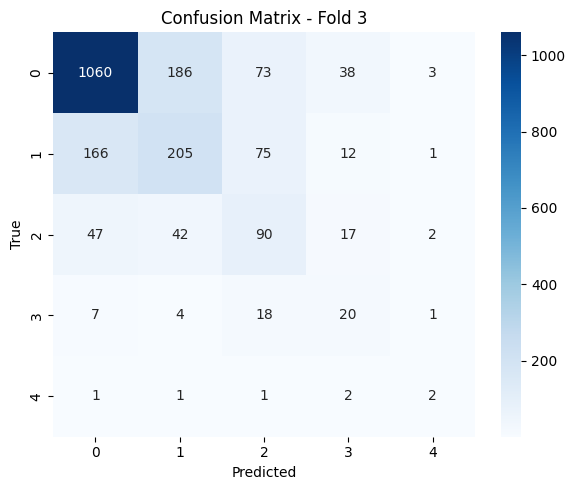

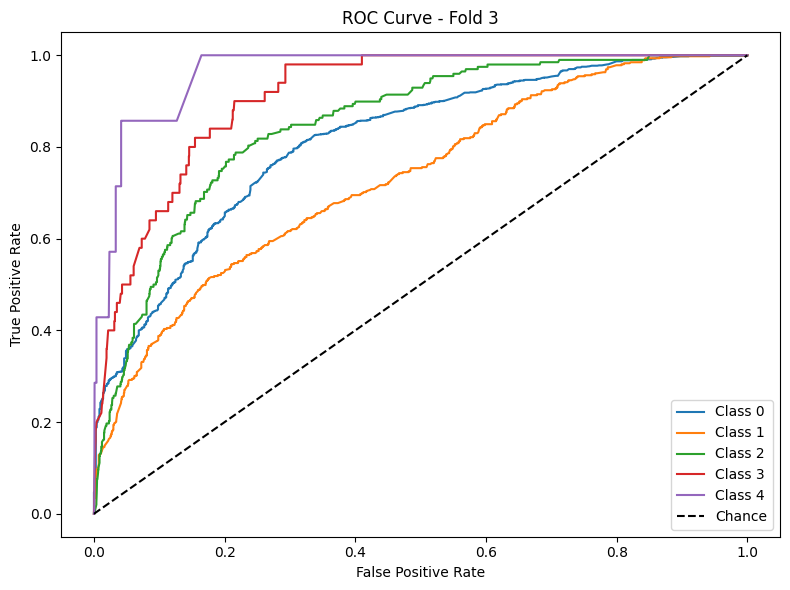


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1360
           1       0.47      0.46      0.46       459
           2       0.43      0.47      0.45       198
           3       0.26      0.42      0.32        50
           4       0.17      0.29      0.21         7

    accuracy                           0.67      2074
   macro avg       0.43      0.49      0.45      2074
weighted avg       0.69      0.67      0.68      2074



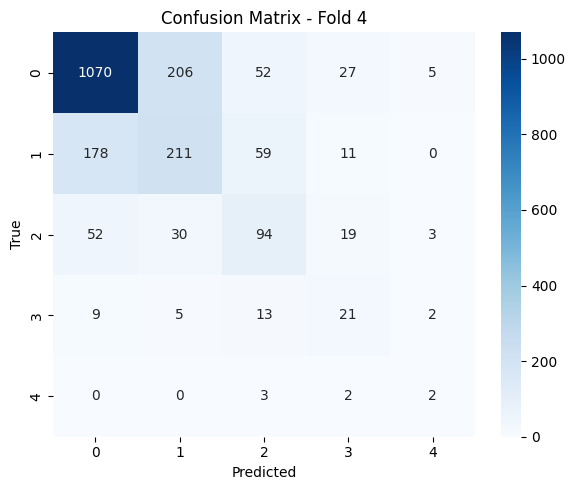

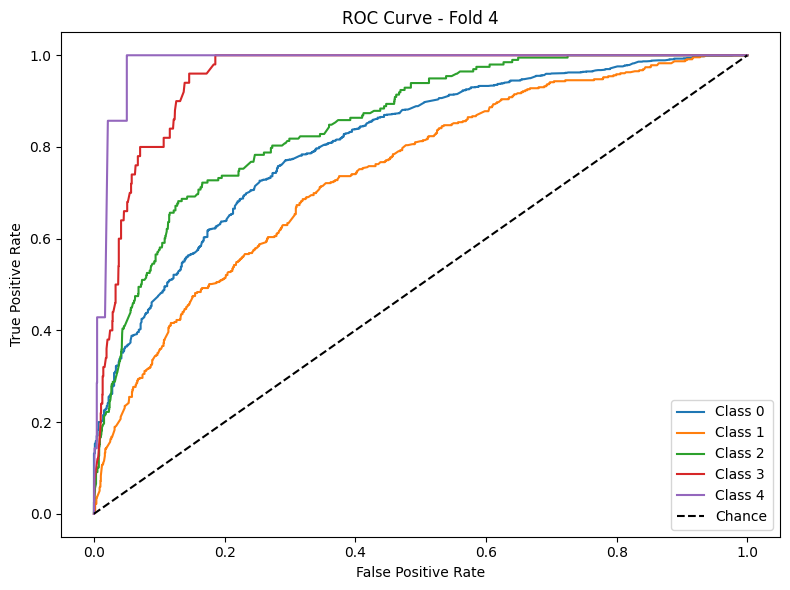


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      1360
           1       0.47      0.48      0.48       460
           2       0.40      0.50      0.44       197
           3       0.21      0.37      0.26        49
           4       0.12      0.14      0.13         7

    accuracy                           0.66      2073
   macro avg       0.40      0.45      0.42      2073
weighted avg       0.69      0.66      0.67      2073



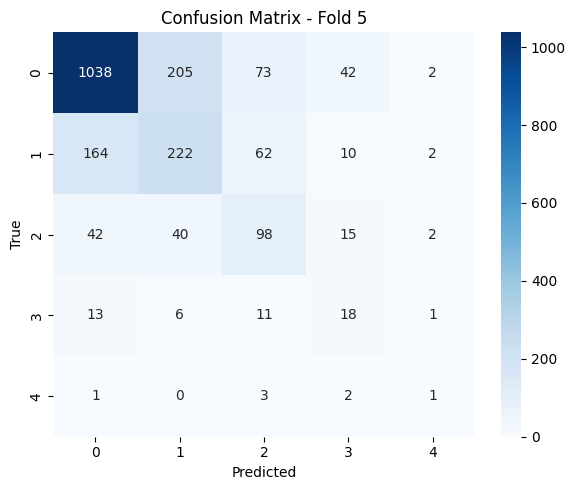

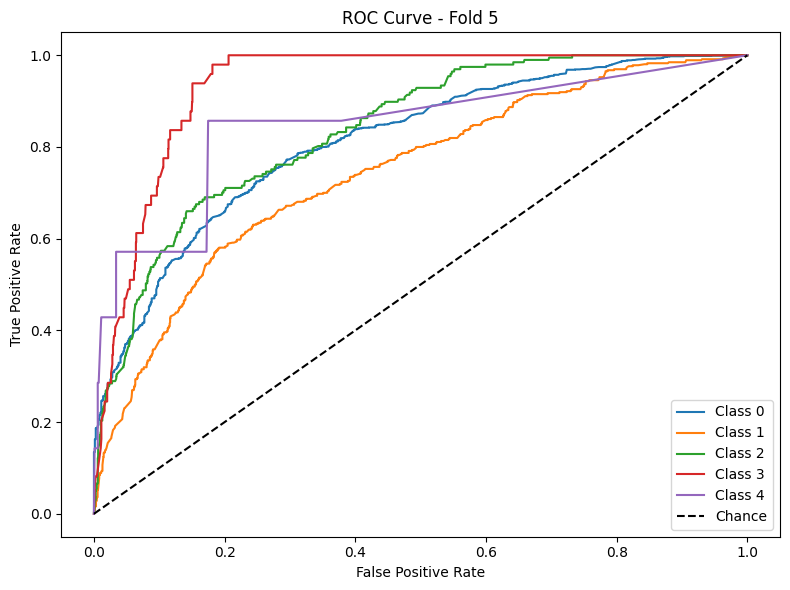


Average Accuracy: 0.6761
Average F1 Macro: 0.4498
Average AUC: 0.8559

Feature Importances:
assignment                             0.107063
video                                  0.102417
remaining_time                         0.098116
school                                 0.074046
encoded_field_sum                      0.070778
video_count                            0.064785
exercise_count                         0.060440
user_month                             0.056050
chapter_count                          0.052214
duration_days                          0.048865
num_prerequisites                      0.026147
total_words_phase1                     0.021907
total_neutral1                         0.017042
certificate                            0.014238
user_past_course_count                 0.012943
exam                                   0.012096
total_words_phase3                     0.011375
total_positive1                        0.010513
total_words_phase2                     0.00

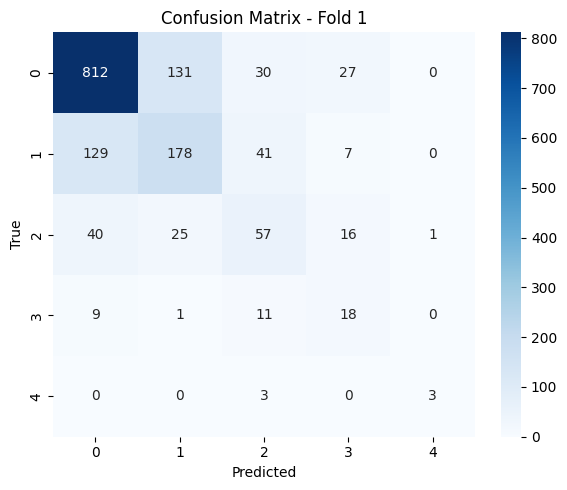

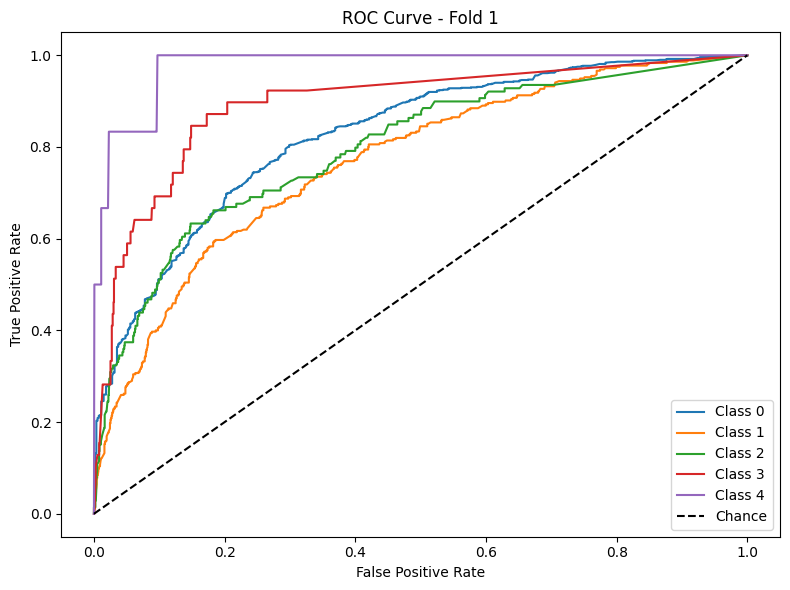


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.49      0.49      0.49       355
           2       0.55      0.52      0.53       139
           3       0.29      0.45      0.35        40
           4       0.00      0.00      0.00         5

    accuracy                           0.68      1539
   macro avg       0.43      0.45      0.43      1539
weighted avg       0.70      0.68      0.69      1539



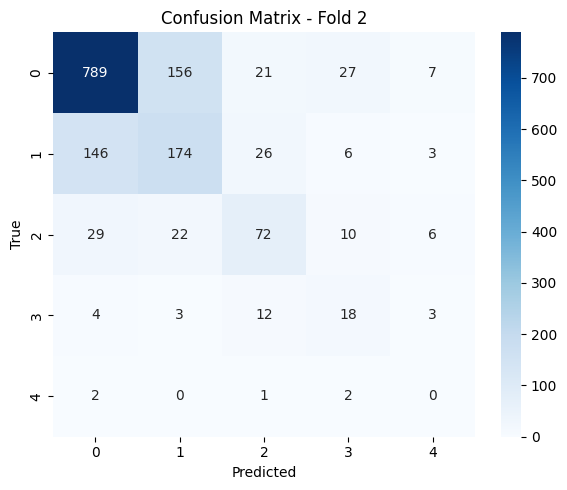

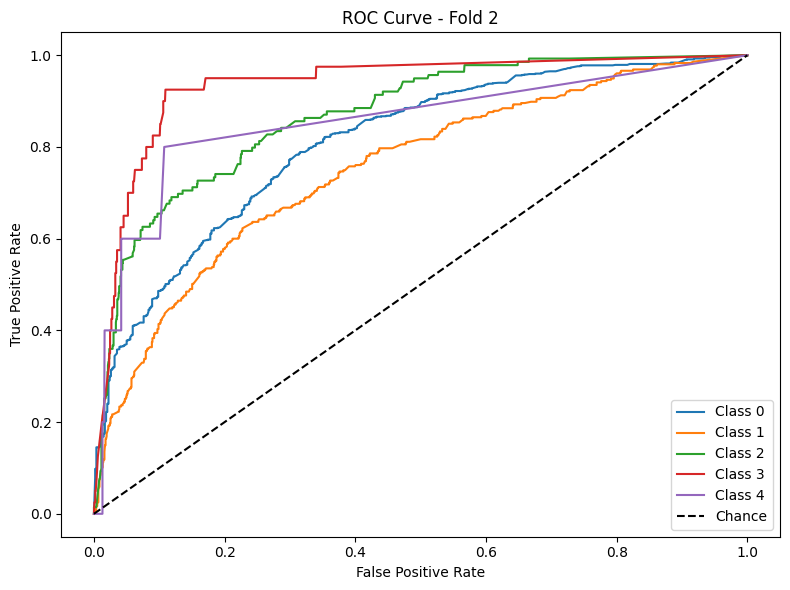


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       999
           1       0.54      0.55      0.54       355
           2       0.47      0.50      0.49       139
           3       0.27      0.40      0.32        40
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1539
   macro avg       0.42      0.45      0.43      1539
weighted avg       0.71      0.70      0.71      1539



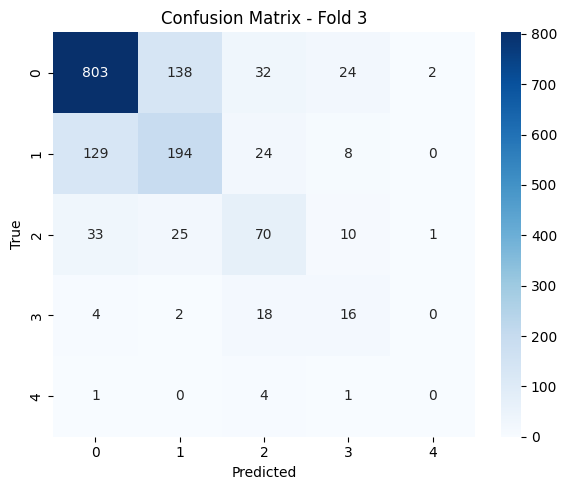

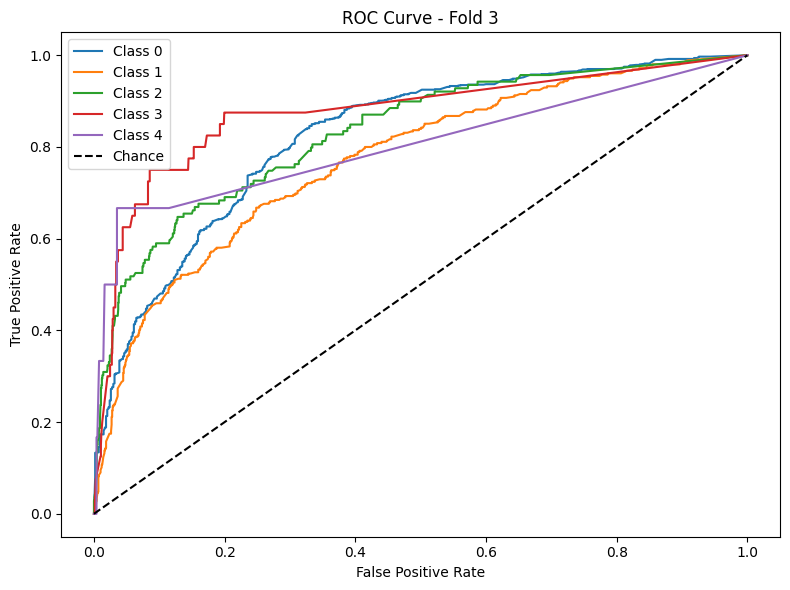


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       999
           1       0.52      0.50      0.51       356
           2       0.47      0.47      0.47       138
           3       0.28      0.49      0.35        39
           4       0.24      0.67      0.35         6

    accuracy                           0.70      1538
   macro avg       0.47      0.59      0.50      1538
weighted avg       0.71      0.70      0.70      1538



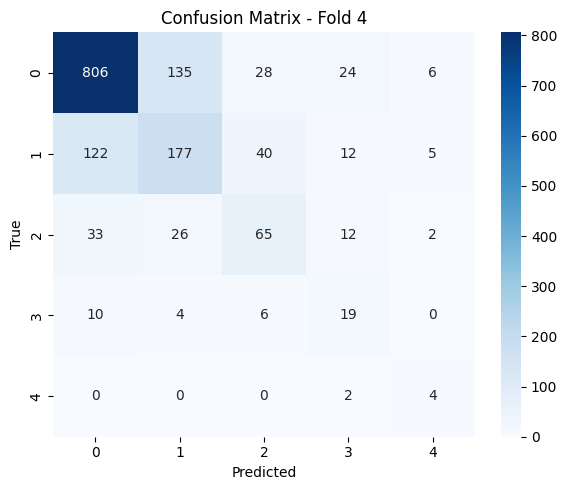

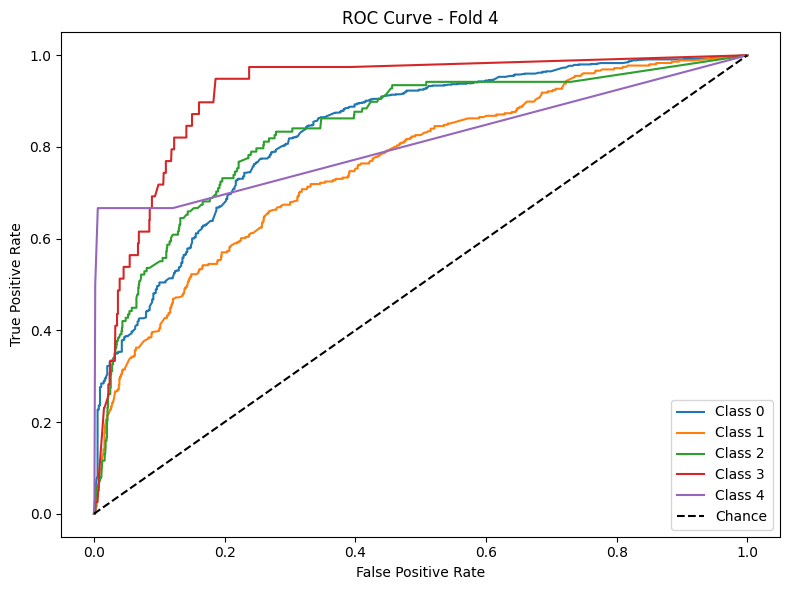


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       999
           1       0.53      0.51      0.52       356
           2       0.43      0.41      0.42       138
           3       0.31      0.51      0.39        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1538
   macro avg       0.42      0.45      0.43      1538
weighted avg       0.70      0.70      0.70      1538



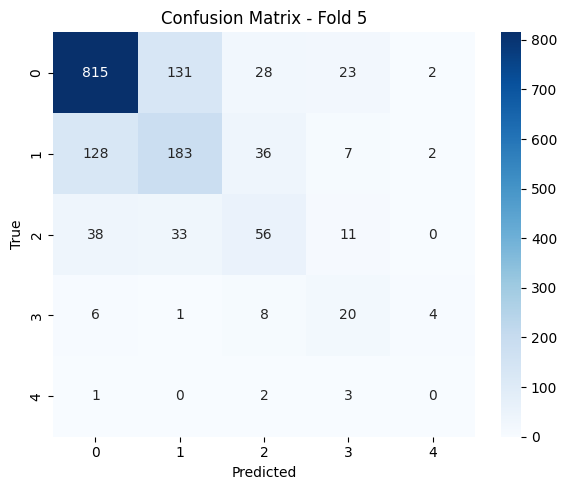

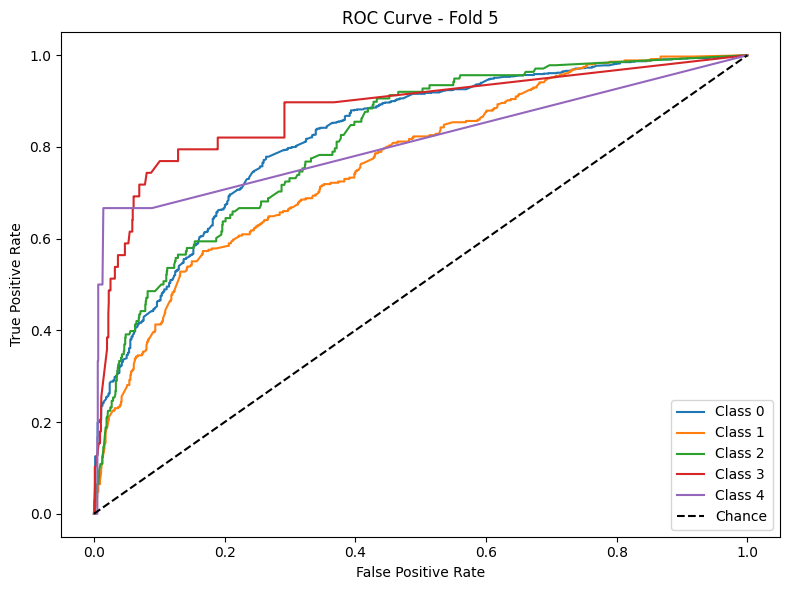


Average Accuracy: 0.6953
Average F1 Macro: 0.4663
Average AUC: 0.8335

Feature Importances:
remaining_time                         1.212489e-01
assignment                             9.272440e-02
video                                  8.639141e-02
school                                 6.930054e-02
encoded_field_sum                      6.467487e-02
video_count                            6.166757e-02
user_month                             5.459025e-02
exercise_count                         5.340903e-02
chapter_count                          5.001614e-02
duration_days                          4.834766e-02
num_prerequisites                      2.224612e-02
total_words_phase1                     1.986364e-02
total_neutral1                         1.482432e-02
total_words_phase4                     1.275353e-02
certificate                            1.244313e-02
user_past_course_count                 1.160873e-02
total_neutral4                         9.071037e-03
exercise_correct_sum_4 

In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       568
           1       0.38      0.35      0.36        63
           2       0.53      0.23      0.32        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.36      0.31      0.32       698
weighted avg       0.78      0.82      0.79       698



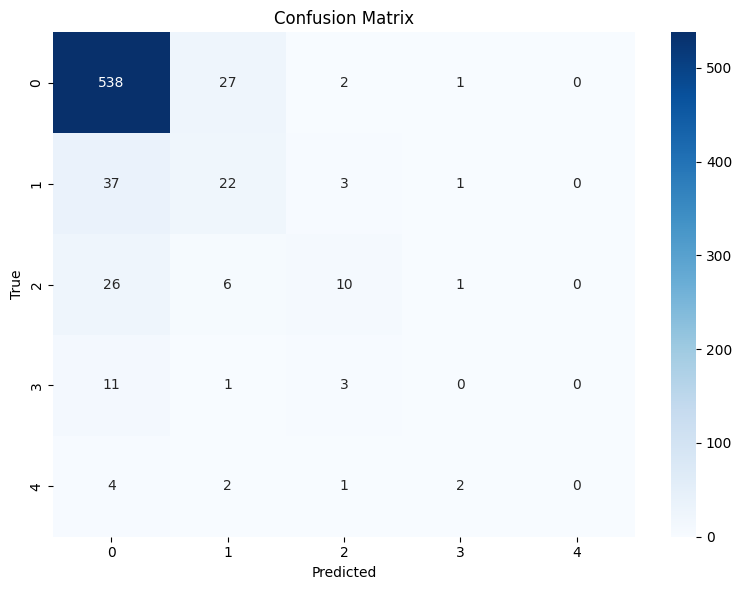


Test AUC (macro-average, OVR): 0.8119


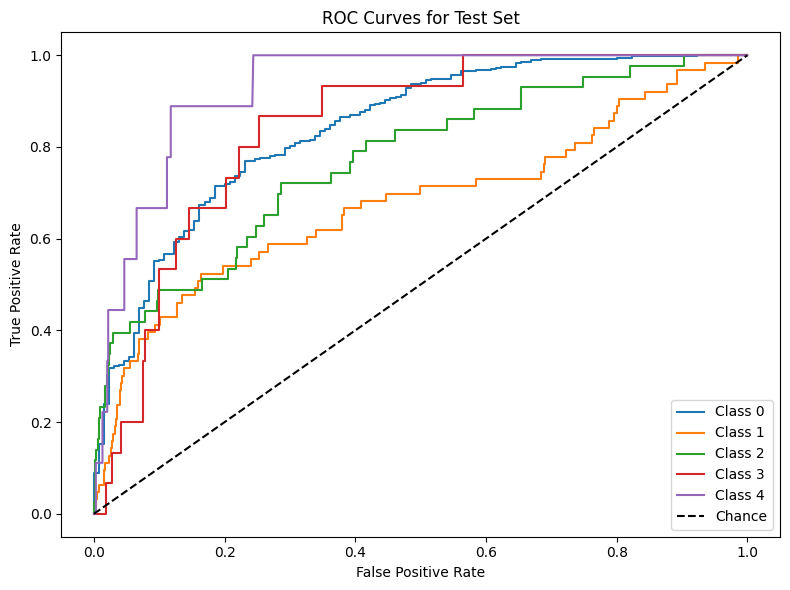

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       544
           1       0.27      0.22      0.24        59
           2       0.47      0.17      0.25        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.32      0.27      0.28       668
weighted avg       0.76      0.81      0.78       668



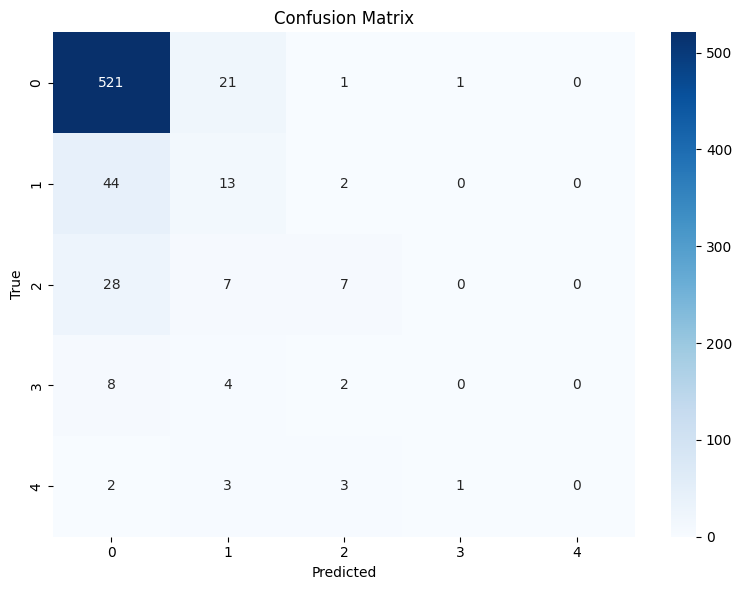


Test AUC (macro-average, OVR): 0.7866


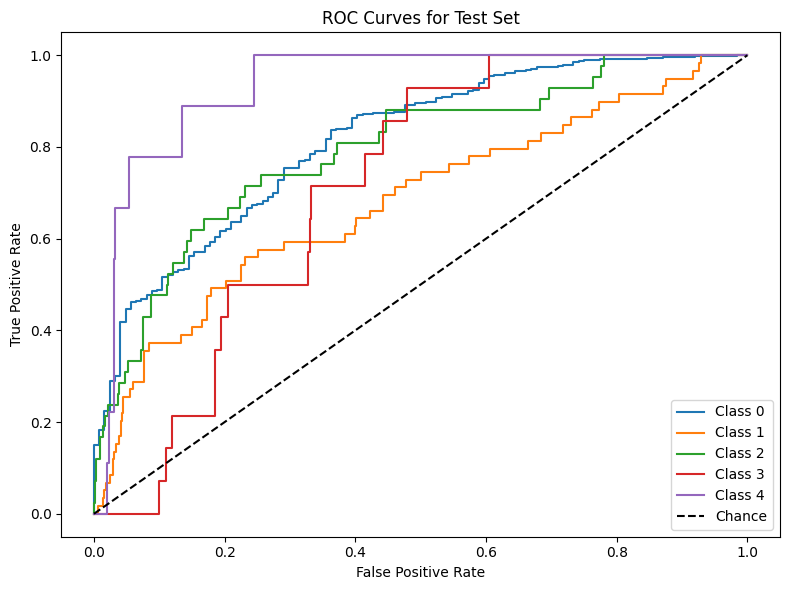

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       455
           1       0.29      0.19      0.23        52
           2       0.25      0.07      0.11        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       554
   macro avg       0.28      0.24      0.25       554
weighted avg       0.74      0.81      0.77       554



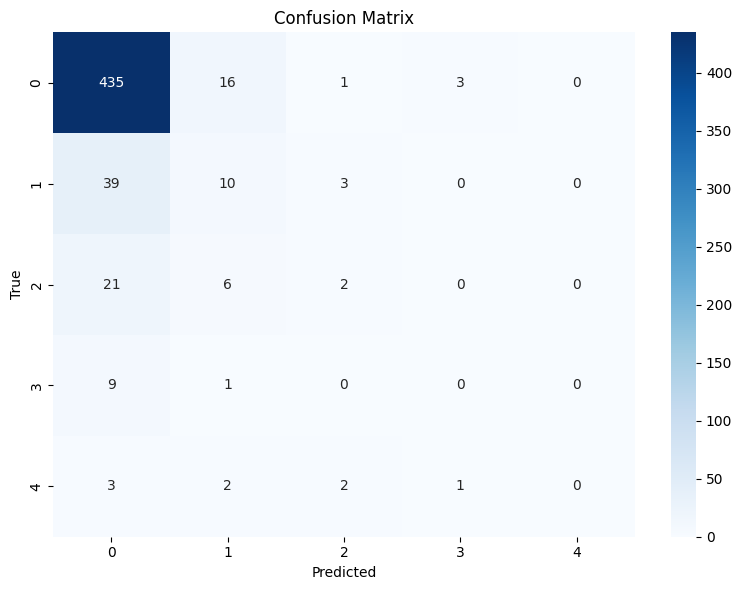


Test AUC (macro-average, OVR): 0.7896


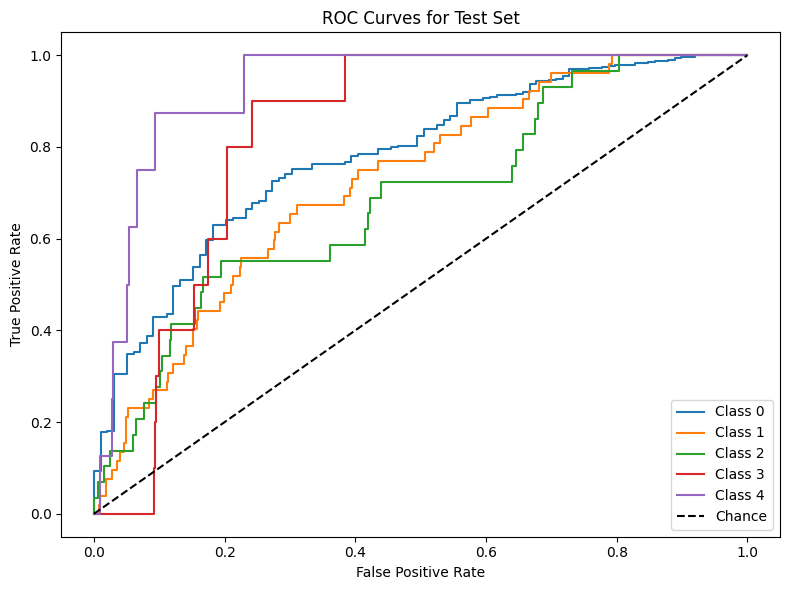

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       395
           1       0.29      0.28      0.28        40
           2       0.09      0.04      0.06        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.25      0.25      0.25       477
weighted avg       0.75      0.79      0.77       477



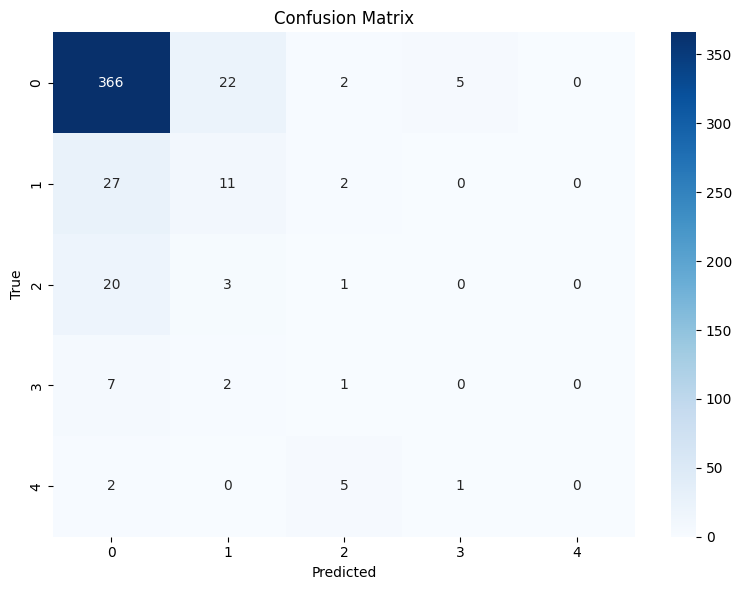


Test AUC (macro-average, OVR): 0.7520


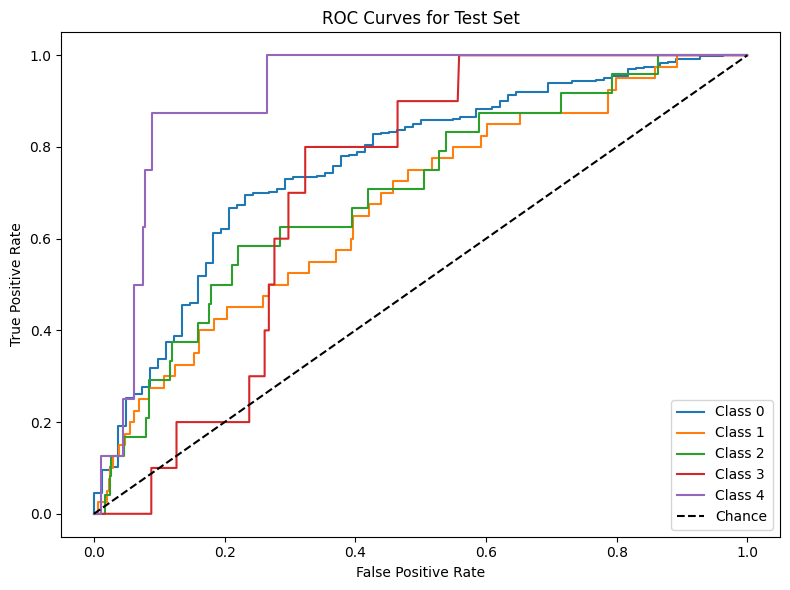

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
